<a href="https://colab.research.google.com/github/MatthewBenning/Statistics-Honours-Research-Project/blob/main/cointegation_002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Matthew Benning
# Statistics Honours Research Project 
# Pairs Trading using ML Forecasting: Does it improve PnL on JSE listed equities?
# Does the Kalman filter, which makes assumptions about linearity 
# In this script, I combine all the work I have done

import numpy as np 
import pandas as pd 
import random 
import tensorflow as ts

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam  
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/Statistics Honours Research Project'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


# New section

In [ ]:
# First read in the JSE data set and convert it to a timeseries object
data = pd.read_excel('/content/gdrive/MyDrive/Statistics Honours Research Project/jse_data_ready.xlsx',index_col=0)
print(data)

# Make sure that we removed all the NA data values in the R script 
data = data.dropna()

In [ ]:
# Find the cointegrated pairs 
# Use only the first 70% of the data to find the cointegrated pairs, because this
# be our in-sample data. We dont want to have any insight as to whether pairs are 
# cointegrated when we are doing OOS and this will increase PBO

# Keep a copy of original data
data_orig = data

# Work with log prices for Kalman
data = np.log(data)


split = int(0.70*len(data))
data_train = data[:split]
data_train.head()

data_test = data[split:]
data_test.head()

# Data is from 2010/01/04 until 2019/12/31
# Train from 2010/01/04 to 2016/12/30
# Trading period from 2017/01/03 to 2019/12/31

# Now we can normalize the data sets, since we didn't want to increase bias

data_train = (data_train-data_train.mean())/data_train.std()
data_test = (data_test-data_test.mean())/data_test.std()

data_train.head()
data_test.head()



,ABG.JO,AFE.JO,AGL.JO,AMS.JO,ANG.JO,APN.JO,ARI.JO,AVI.JO,BAW.JO,BHP.JO,BTI.JO,BVT.JO,CCO.JO,CFR.JO,CLS.JO,CML.JO,CPI.JO,DSY.JO,EXX.JO,FFA.JO,FSR.JO,GFI.JO,GLD.JO,GRT.JO,HAR.JO,IMP.JO,INL.JO,INP.JO,IPL.JO,ITE.JO,KIO.JO,LBH.JO,LHC.JO,MNP.JO,MRP.JO,MSM.JO,MTM.JO,MTN.JO,NED.JO,NPN.JO,NRP.JO,NTC.JO,PIK.JO,PSG.JO,RCL.JO,RDF.JO,REM.JO,RES.JO,RMI.JO,SAP.JO,SBK.JO,SHP.JO,SLM.JO,SNT.JO,SOL.JO,SPG.JO,SPP.JO,SYGWD.JO,TBS.JO,TFG.JO,TKG.JO,TRU.JO,TSG.JO,VKE.JO,VOD.JO,WHL.JO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,-0.406022,-1.216108,-1.561871,-1.231206,-0.206395,0.832152,-1.002442,-1.774161,-1.065751,-1.297393,0.470561,-0.828158,0.222825,-2.595317,-2.166347,0.626277,-1.774838,-1.822371,-2.160319,-1.242836,-1.222950,-0.915313,-1.014217,-1.365145,0.323365,0.138799,-2.058140,-1.857186,0.599604,-0.717804,-1.778778,-1.259659,1.624791,-2.265229,-1.429706,0.629366,1.260388,0.759852,-0.846602,-2.700016,0.476115,1.239860,-0.996966,-2.045502,-1.002782,0.189564,0.816011,0.634344,0.180263,0.500749,-1.564448,-0.644000,-2.192765,-1.918498,-0.154491,0.692513,0.061102,-1.458300,0.741968,-0.939523,0.373506,-0.225334,1.337673,-2.088468,0.146776,1.504509
2017-01-04,-0.318007,-1.256559,-1.673259,-1.189496,-0.157916,0.837617,-0.957875,-1.770004,-1.052388,-1.388652,0.410772,-0.916848,0.298996,-2.817976,-2.290863,0.630171,-1.804493,-1.717368,-2.272777,-1.275158,-1.178136,-0.887339,-1.030799,-1.291129,0.379986,0.175394,-2.014940,-1.962795,0.633307,-0.790645,-1.763619,-0.868744,1.616602,-2.447576,-1.478241,0.624863,1.558055,0.936368,-0.877595,-2.754001,0.464358,1.298624,-1.092233,-1.943020,-0.703872,-0.089896,0.863559,0.721392,0.361895,0.476122,-1.612045,-0.770285,-2.026044,-1.963036,-0.184406,0.741997,0.104384,-1.450463,0.695838,-0.936634,0.441145,-0.245738,1.286587,-1.733292,0.249044,1.381361
2017-01-05,-0.574111,-1.237764,-1.662358,-1.109278,-0.050205,0.776108,-0.959540,-1.656883,-1.159253,-1.338771,0.396122,-1.133944,0.537912,-2.864067,-2.377264,0.493797,-1.794587,-1.876724,-2.270250,-1.422538,-1.364234,-0.744860,-0.955138,-1.520458,0.557089,0.260460,-2.138310,-1.939513,0.597464,-0.937450,-1.786697,-1.144840,1.686059,-2.423613,-1.617636,0.568699,1.353615,0.801401,-1.102085,-2.739095,0.454051,1.284961,-1.159211,-2.004699,-1.052657,-0.317046,0.648708,0.681176,0.106648,0.458188,-1.728560,-0.790099,-2.207661,-2.003644,-0.252553,0.685743,0.098725,-1.473993,0.719400,-1.026198,0.425999,-0.449450,1.146723,-1.825333,0.198039,1.139567
2017-01-06,-0.432077,-1.208895,-1.643640,-1.131109,-0.025788,0.778752,-1.012914,-1.740935,-1.083827,-1.287105,0.413763,-1.165332,0.716534,-2.549062,-2.336237,0.500180,-1.796962,-1.765888,-2.276992,-1.150757,-1.292596,-0.779113,-0.931733,-1.272678,0.593942,0.257110,-2.110103,-1.857186,0.591308,-0.593784,-1.823729,-1.040706,1.840031,-2.384349,-1.624321,0.516498,1.406950,1.048408,-1.053473,-2.433165,0.475748,1.290821,-1.000548,-1.946520,-0.764132,0.050446,0.880457,0.694951,0.074571,0.477400,-1.665470,-0.825030,-2.092086,-1.966153,-0.195475,0.676709,-0.029136,-1.419180,0.779939,-0.936153,0.420534,-0.499995,1.100591,-1.767716,0.171090,1.231141
2017-01-09,-0.423209,-1.382979,-1.671001,-1.191992,-0.104633,0.776108,-1.054774,-1.663751,-1.091873,-1.327969,0.437750,-1.110709,0.344904,-2.447223,-2.302380,0.423905,-1.808395,-1.860055,-2.287127,-1.150757,-1.276646,-0.817308,-0.885094,-1.192966,0.500549,0.244919,-2.205732,-1.958558,0.596812,-0.937450,-1.855979,-1.203199,1.632977,-2.546511,-1.643422,0.594647,1.357181,0.953220,-0.922464,-2.423860,0.475748,1.300573,-0.794701,-2.102683,-0.785812,-0.061727,0.693506,0.739441,0.029985,0.458188,-1.610679,-0.786846,-2.070020,-2.003644,-0.231325,0.604095,0.014528,-1.446547,0.782934,-0.965565,0.420534,-0.516386,1.100591,-1.953181,0.277789,1.119245


In [ ]:

# Plot the prices over the investigated period 
fig, ax = plt.subplots(3, 1,figsize=(20,10))

ax[0].plot(data_train.iloc[:,0:25])
plt.ylabel('Normalized Log Price')
ax[1].plot(data_train.iloc[:,26:50])
plt.ylabel('Normalized Log Price')
ax[2].plot(data_train.iloc[:,51:])
plt.xlabel('Date')
plt.ylabel('Normalized Log Price')
plt.show()
plt.savefig(f"all_asset_paths.png")

# Scale the data 
#data_train=(data_train-data_train.min())/(data_train.max()-data_train.min())

In [ ]:
# Set up the cointegration test
# Making use of the coint() function provided in the stats.mopackage
def coint_pairs(data): 
  
  n=data.shape[1]
  score_matrix = np.zeros((n,n))
  pvalue_matrix = np.ones((n,n))
  pairs =[]
  keys = data.keys()

  # Loop through all assets, checking the cointegrability with all the others
  for i in range(n):
    for j in range(i+2,n):
      asset_1 = data[keys[i+1]]
      asset_2 = data[keys[j]]
      result = coint(asset_1,asset_2)
      score = result[0]
      pvalue = result[1]
      score_matrix[i,j]= score
      pvalue_matrix[i,j]= pvalue
      
      # Set a target threshold for the pairs we accept
      # We use a 5% significance level/p-value
      # Obviosuly this is does not imply cointegrated but just a good guide 
      if pvalue < 0.025:
        pairs.append((keys[i],keys[j]))

  return pairs, score_matrix, pvalue_matrix 

# Obtain the cointegrated pairs for only the training data
results1 = coint_pairs(data_orig)

In [ ]:
# Only run this cell the first time - use next cell to load pairs
# Potential Pairs 
pot_pairs = pd.DataFrame(results1[0], columns=['Asset1','Asset2'])
print(pot_pairs)

pot_pairs_save = pot_pairs[:]
print(pot_pairs_save)  

pot_pairs_save.to_csv('/content/gdrive/MyDrive/Statistics Honours Research Project/potential_pairs_save.csv')

    Asset1    Asset2
0   AMS.JO    RCL.JO
1   ARI.JO    GRT.JO
2   ARI.JO    MNP.JO
3   ARI.JO    RDF.JO
4   BHP.JO    VOD.JO
5   BVT.JO    LHC.JO
6   BVT.JO    NTC.JO
7   BVT.JO    WHL.JO
8   CCO.JO    LBH.JO
9   CPI.JO    MNP.JO
10  CPI.JO    RDF.JO
11  FFA.JO    NPN.JO
12  FFA.JO    SNT.JO
13  FFA.JO  SYGWD.JO
14  FFA.JO    VKE.JO
15  GFI.JO    SPP.JO
16  GLD.JO    SLM.JO
17  IMP.JO    ITE.JO
18  IMP.JO    MNP.JO
19  INL.JO    ITE.JO
20  INL.JO    MNP.JO
21  IPL.JO    MNP.JO
22  IPL.JO    PIK.JO
23  IPL.JO    PSG.JO
24  IPL.JO    SPP.JO
25  IPL.JO  SYGWD.JO
26  LHC.JO    PIK.JO
27  LHC.JO    RDF.JO
28  LHC.JO    SPP.JO
29  MTN.JO    SNT.JO
30  NED.JO    VKE.JO
31  NPN.JO    RDF.JO
32  NPN.JO    VOD.JO
33  NTC.JO    PSG.JO
34  NTC.JO    SPP.JO
35  NTC.JO  SYGWD.JO
36  PSG.JO    SOL.JO
37  RCL.JO    VOD.JO
38  RDF.JO    SPG.JO
39  REM.JO    VOD.JO
40  SBK.JO    TBS.JO
41  SBK.JO    TRU.JO
42  SHP.JO  SYGWD.JO
43  SLM.JO    TFG.JO
44  SLM.JO    VKE.JO
45  SOL.JO    VOD.JO
46  SPG.JO  S

In [ ]:
# Read in potential pairs
pot_pairs = pd.read_csv('/content/gdrive/MyDrive/Statistics Honours Research Project/potential_pairs_save.csv',index_col=0)
print(pot_pairs)

In [ ]:
# Total number of cointegrated pairs found
print(len(pot_pairs))

101


In [ ]:
# Now we set up the mean reverting series that we will be trying to trade
# as well as finding the static hedge ratio 
# done in function form so that we can easily repeat it

def pairs_setup(tick_1,tick_2):

  # Plot the price path 
  plt.plot(data_train[tick_1], color='red', label=tick_1)
  plt.plot(data_train[tick_2], color='blue',label=tick_2)
  plt.ylabel('Adjusted Price (ZAC)')
  plt.xlabel("Date")
  plt.legend(framealpha=1, frameon=True) 
  plt.savefig(f"{images_dir}/{tick_1}.png")
  plt.show()
 

  # Now we find the hedge ratio and spread 
  asset_1= np.array(data_train[tick_1]).reshape(-1,1)
  asset_2= np.array(data_train[tick_2]).reshape(-1,1)

  # Obtain the static hedge ratio, using OLS
  reg = LinearRegression().fit(asset_1 ,asset_2)
  static_hedge_ratio = reg.coef_[0][0]

  # Spread
  spread_train = data_train[tick_2] -static_hedge_ratio*data_train[tick_1]
  spread_test = data_test[tick_2] -static_hedge_ratio*data_test[tick_1]
  spread = np.hstack([spread_train,spread_test])

  # Plot the spread
  plt.plot(spread_train,color='black', label='Using static hedge ratio') 
  plt.ylabel('Spread') 
  plt.xlabel("Date") 
  plt.legend(framealpha=1, frameon=True) 
  plt.savefig(f"{images_dir}/spread{tick_1}.png")
  plt.show()

  return asset_1, asset_2, spread_train, spread_test, static_hedge_ratio,spread
  


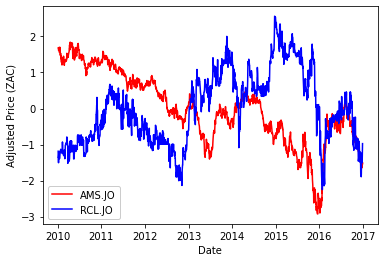

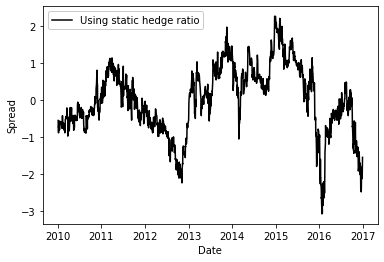

(array([[ 1.68015133],
       [ 1.66893916],
       [ 1.66144076],
       ...,
       [-1.50657554],
       [-1.55092274],
       [-1.50964066]]), array([[-1.18576645],
       [-1.35529387],
       [-1.34939534],
       ...,
       [-1.3079112 ],
       [-1.23260922],
       [-0.97375995]]), Date
2010-01-04   -0.550285
2010-01-05   -0.724053
2010-01-06   -0.720990
2010-01-07   -0.884118
2010-01-08   -0.688131
                ...   
2016-12-23   -2.119048
2016-12-27   -2.119048
2016-12-28   -1.877742
2016-12-29   -1.819213
2016-12-30   -1.544750
Length: 1752, dtype: float64, Date
2017-01-03   -1.468460
2017-01-04   -1.153774
2017-01-05   -1.472218
2017-01-06   -1.191950
2017-01-09   -1.236657
                ...   
2019-12-23   -0.472085
2019-12-24   -0.241536
2019-12-27   -0.256781
2019-12-30   -0.274868
2019-12-31   -0.425651
Length: 752, dtype: float64, -0.37822890744611565, array([-0.55028464, -0.72405284, -0.72099041, ..., -0.25678144,
       -0.27486846, -0.42565115]))


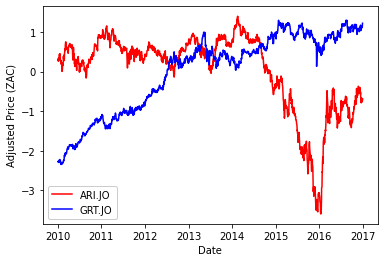

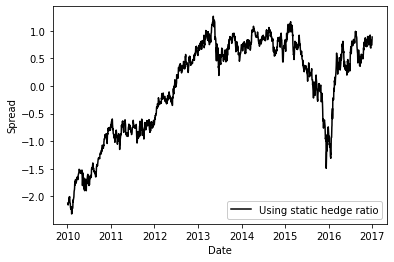

(array([[ 0.30118009],
       [ 0.27056585],
       [ 0.33953599],
       ...,
       [-0.6751315 ],
       [-0.72695411],
       [-0.69267735]]), array([[-2.26811461],
       [-2.25897619],
       [-2.2910756 ],
       ...,
       [ 1.15260051],
       [ 1.1925948 ],
       [ 1.2210336 ]]), Date
2010-01-04   -2.123456
2010-01-05   -2.129022
2010-01-06   -2.127994
2010-01-07   -2.156552
2010-01-08   -2.134916
                ...   
2016-12-23    0.742323
2016-12-27    0.742323
2016-12-28    0.828331
2016-12-29    0.843435
2016-12-30    0.888337
Length: 1752, dtype: float64, Date
2017-01-03   -1.846624
2017-01-04   -1.751202
2017-01-05   -1.981331
2017-01-06   -1.759186
2017-01-09   -1.699580
                ...   
2019-12-23    0.713038
2019-12-24    0.683931
2019-12-27    0.768210
2019-12-30    0.872630
2019-12-31    0.719991
Length: 752, dtype: float64, -0.48030579226538894, array([-2.12345607, -2.12902184, -2.1279945 , ...,  0.7682104 ,
        0.87262989,  0.71999135]))


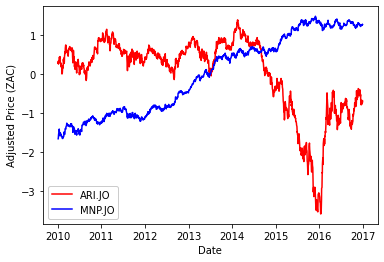

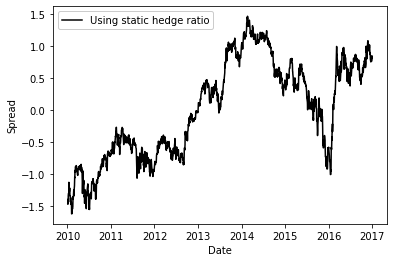

(array([[ 0.30118009],
       [ 0.27056585],
       [ 0.33953599],
       ...,
       [-0.6751315 ],
       [-0.72695411],
       [-0.69267735]]), array([[-1.65954178],
       [-1.64913081],
       [-1.61497045],
       ...,
       [ 1.2812219 ],
       [ 1.27007939],
       [ 1.27614468]]), Date
2010-01-04   -1.467483
2010-01-05   -1.476594
2010-01-06   -1.398452
2010-01-07   -1.438801
2010-01-08   -1.339355
                ...   
2016-12-23    0.769387
2016-12-27    0.769387
2016-12-28    0.850698
2016-12-29    0.806509
2016-12-30    0.834432
Length: 1752, dtype: float64, Date
2017-01-03   -2.904475
2017-01-04   -3.058402
2017-01-05   -3.035500
2017-01-06   -3.030272
2017-01-09   -3.219129
                ...   
2019-12-23    1.130831
2019-12-24    1.139229
2019-12-27    1.271536
2019-12-30    1.361807
2019-12-31    1.286093
Length: 752, dtype: float64, -0.6376884356625682, array([-1.46748272, -1.47659409, -1.39845227, ...,  1.27153553,
        1.36180668,  1.28609305]))


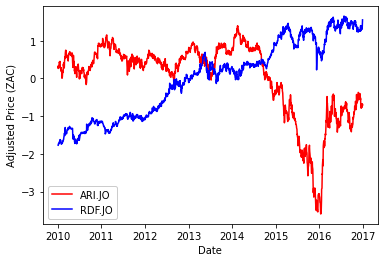

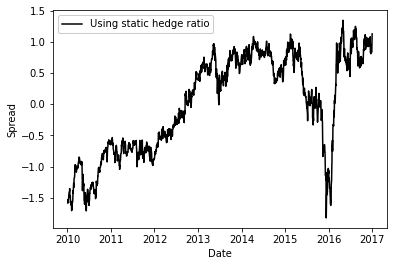

(array([[ 0.30118009],
       [ 0.27056585],
       [ 0.33953599],
       ...,
       [-0.6751315 ],
       [-0.72695411],
       [-0.69267735]]), array([[-1.77108541],
       [-1.73765421],
       [-1.73765421],
       ...,
       [ 1.42406581],
       [ 1.48038871],
       [ 1.55406184]]), Date
2010-01-04   -1.588236
2010-01-05   -1.573391
2010-01-06   -1.531518
2010-01-07   -1.576344
2010-01-08   -1.550055
                ...   
2016-12-23    0.841097
2016-12-27    0.841097
2016-12-28    1.014186
2016-12-29    1.039047
2016-12-30    1.133530
Length: 1752, dtype: float64, Date
2017-01-03   -0.419030
2017-01-04   -0.671432
2017-01-05   -0.899593
2017-01-06   -0.564505
2017-01-09   -0.702092
                ...   
2019-12-23   -1.052253
2019-12-24   -1.212899
2019-12-27   -1.112855
2019-12-30   -0.930491
2019-12-31   -0.985725
Length: 752, dtype: float64, -0.6071108324766746, array([-1.58823572, -1.57339075, -1.53151823, ..., -1.11285518,
       -0.93049052, -0.9857249 ]))


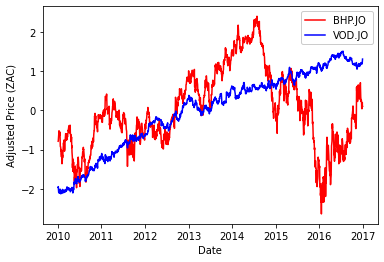

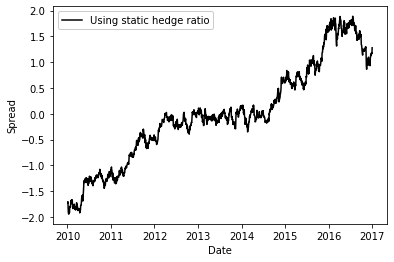

(array([[-0.78538856],
       [-0.77904878],
       [-0.73045735],
       ...,
       [ 0.20461238],
       [ 0.0985789 ],
       [ 0.10351253]]), array([[-1.96447719],
       [-1.94427386],
       [-2.00707562],
       ...,
       [ 1.22682169],
       [ 1.27261432],
       [ 1.31147684]]), Date
2010-01-04   -1.721663
2010-01-05   -1.703419
2010-01-06   -1.781244
2010-01-07   -1.865017
2010-01-08   -1.889614
                ...   
2016-12-23    1.174862
2016-12-27    1.174862
2016-12-28    1.163563
2016-12-29    1.242137
2016-12-30    1.279474
Length: 1752, dtype: float64, Date
2017-01-03    0.547884
2017-01-04    0.678367
2017-01-05    0.611940
2017-01-06    0.569018
2017-01-09    0.688351
                ...   
2019-12-23   -1.198756
2019-12-24   -1.193646
2019-12-27   -1.215791
2019-12-30   -1.187976
2019-12-31   -1.340319
Length: 752, dtype: float64, 0.3091650117918495, array([-1.72166253, -1.70341924, -1.78124377, ..., -1.21579145,
       -1.18797592, -1.34031922]))


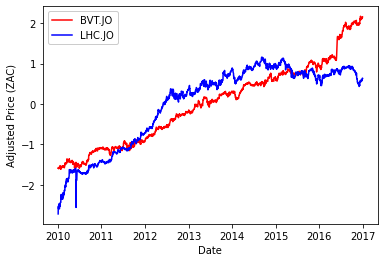

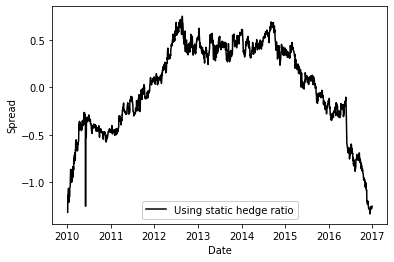

(array([[-1.58942705],
       [-1.57149928],
       [-1.57929485],
       ...,
       [ 2.15841917],
       [ 2.1606447 ],
       [ 2.15559036]]), array([[-2.71757881],
       [-2.52803478],
       [-2.52803478],
       ...,
       [ 0.61574974],
       [ 0.64026425],
       [ 0.63721632]]), Date
2010-01-04   -1.321465
2010-01-05   -1.147668
2010-01-06   -1.140821
2010-01-07   -1.187792
2010-01-08   -1.185655
                ...   
2016-12-23   -1.278739
2016-12-27   -1.278739
2016-12-28   -1.280153
2016-12-29   -1.257593
2016-12-30   -1.256202
Length: 1752, dtype: float64, Date
2017-01-03    2.352225
2017-01-04    2.421939
2017-01-05    2.682088
2017-01-06    2.863630
2017-01-09    2.608597
                ...   
2019-12-23   -0.556604
2019-12-24   -0.569751
2019-12-27   -0.508442
2019-12-30   -0.499826
2019-12-31   -0.604823
Length: 752, dtype: float64, 0.8783755879066786, array([-1.3214649 , -1.14766818, -1.14082074, ..., -0.50844243,
       -0.49982628, -0.6048226 ]))


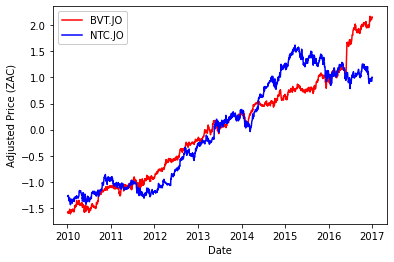

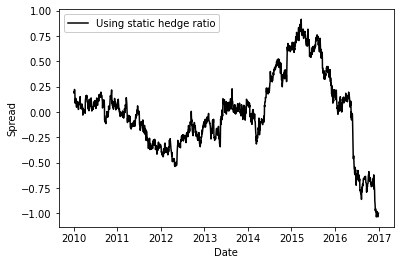

(array([[-1.58942705],
       [-1.57149928],
       [-1.57929485],
       ...,
       [ 2.15841917],
       [ 2.1606447 ],
       [ 2.15559036]]), array([[-1.27628649],
       [-1.27309164],
       [-1.2651237 ],
       ...,
       [ 0.97783959],
       [ 1.00670147],
       [ 1.00123346]]), Date
2010-01-04    0.197960
2010-01-05    0.184526
2010-01-06    0.199725
2010-01-07    0.200383
2010-01-08    0.221768
                ...   
2016-12-23   -1.033620
2016-12-27   -1.033620
2016-12-28   -1.024166
2016-12-29   -0.997368
2016-12-30   -0.998148
Length: 1752, dtype: float64, Date
2017-01-03    2.008004
2017-01-04    2.149031
2017-01-05    2.336732
2017-01-06    2.371705
2017-01-09    2.330793
                ...   
2019-12-23   -1.738796
2019-12-24   -1.719979
2019-12-27   -1.815755
2019-12-30   -1.822092
2019-12-31   -1.789061
Length: 752, dtype: float64, 0.9275332571080984, array([ 0.19795996,  0.18452621,  0.19972479, ..., -1.81575546,
       -1.82209154, -1.78906122]))


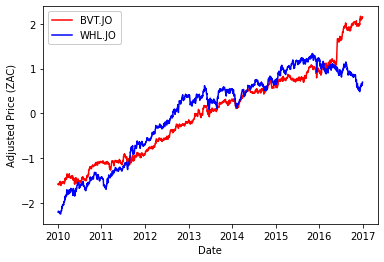

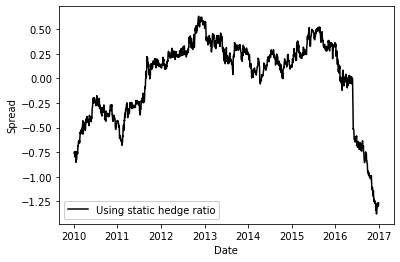

(array([[-1.58942705],
       [-1.57149928],
       [-1.57929485],
       ...,
       [ 2.15841917],
       [ 2.1606447 ],
       [ 2.15559036]]), array([[-2.21090472],
       [-2.19168539],
       [-2.19168539],
       ...,
       [ 0.66643431],
       [ 0.67681396],
       [ 0.69690191]]), Date
2010-01-04   -0.764334
2010-01-05   -0.761431
2010-01-06   -0.754336
2010-01-07   -0.744382
2010-01-08   -0.756603
                ...   
2016-12-23   -1.299471
2016-12-27   -1.299471
2016-12-28   -1.297988
2016-12-29   -1.289634
2016-12-30   -1.264946
Length: 1752, dtype: float64, Date
2017-01-03    2.258233
2017-01-04    2.215804
2017-01-05    2.171593
2017-01-06    2.291734
2017-01-09    2.130124
                ...   
2019-12-23   -1.642260
2019-12-24   -1.602606
2019-12-27   -1.690476
2019-12-30   -1.634683
2019-12-31   -1.728607
Length: 752, dtype: float64, 0.9101207157883924, array([-0.76433424, -0.76143134, -0.75433644, ..., -1.69047584,
       -1.6346827 , -1.72860738]))


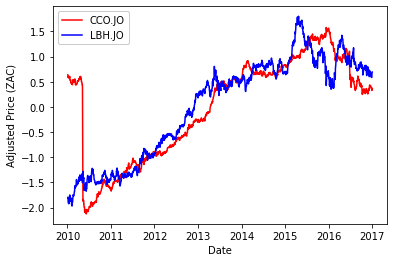

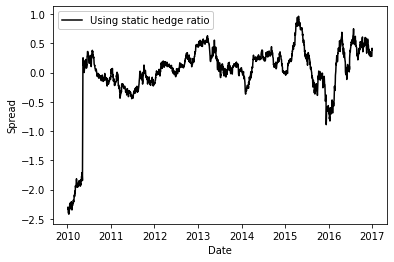

(array([[0.63586459],
       [0.61360664],
       [0.60834153],
       ...,
       [0.32664276],
       [0.33278508],
       [0.36716842]]), array([[-1.80316841],
       [-1.80316841],
       [-1.79064252],
       ...,
       [ 0.64529457],
       [ 0.69244507],
       [ 0.69377343]]), Date
2010-01-04   -2.333028
2010-01-05   -2.314480
2010-01-06   -2.297567
2010-01-07   -2.381422
2010-01-08   -2.397352
                ...   
2016-12-23    0.277922
2016-12-27    0.277922
2016-12-28    0.373107
2016-12-29    0.415139
2016-12-30    0.387816
Length: 1752, dtype: float64, Date
2017-01-03   -1.445337
2017-01-04   -1.117894
2017-01-05   -1.593076
2017-01-06   -1.637786
2017-01-09   -1.490604
                ...   
2019-12-23    1.230965
2019-12-24    0.984338
2019-12-27    1.028602
2019-12-30    0.861974
2019-12-31    0.429311
Length: 752, dtype: float64, 0.8332892117379995, array([-2.33302751, -2.31448021, -2.29756696, ...,  1.02860189,
        0.86197405,  0.42931104]))


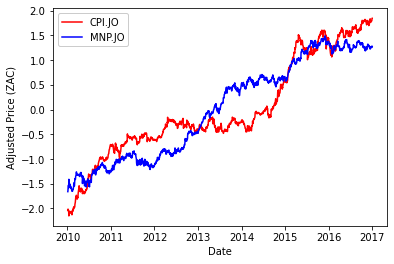

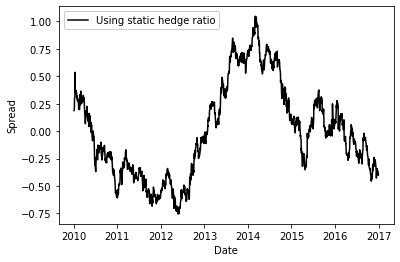

(array([[-2.04119452],
       [-2.03295359],
       [-2.01253187],
       ...,
       [ 1.8417112 ],
       [ 1.84760882],
       [ 1.84760882]]), array([[-1.65954178],
       [-1.64913081],
       [-1.61497045],
       ...,
       [ 1.2812219 ],
       [ 1.27007939],
       [ 1.27614468]]), Date
2010-01-04    0.187286
2010-01-05    0.190241
2010-01-06    0.205924
2010-01-07    0.220022
2010-01-08    0.300540
                ...   
2016-12-23   -0.367003
2016-12-27   -0.367003
2016-12-28   -0.385118
2016-12-29   -0.401597
2016-12-30   -0.395531
Length: 1752, dtype: float64, Date
2017-01-03   -0.659395
2017-01-04   -0.814910
2017-01-05   -0.799910
2017-01-06   -0.758497
2017-01-09   -0.910315
                ...   
2019-12-23   -1.344183
2019-12-24   -1.363328
2019-12-27   -1.241991
2019-12-30   -1.186687
2019-12-31   -1.231475
Length: 752, dtype: float64, 0.9047781514506742, array([ 0.18728642,  0.19024119,  0.20592441, ..., -1.24199123,
       -1.18668679, -1.23147479]))


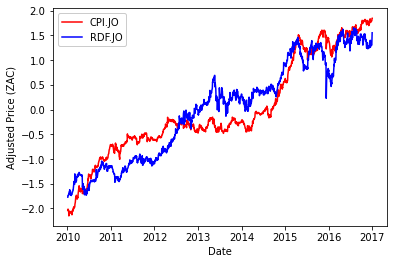

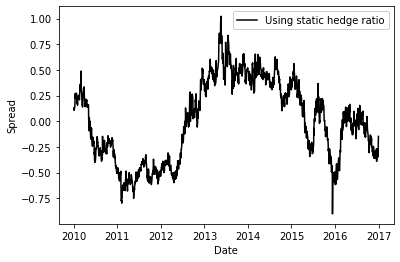

(array([[-2.04119452],
       [-2.03295359],
       [-2.01253187],
       ...,
       [ 1.8417112 ],
       [ 1.84760882],
       [ 1.84760882]]), array([[-1.77108541],
       [-1.73765421],
       [-1.73765421],
       ...,
       [ 1.42406581],
       [ 1.48038871],
       [ 1.55406184]]), Date
2010-01-04    0.108284
2010-01-05    0.134128
2010-01-06    0.115325
2010-01-07    0.122818
2010-01-08    0.131328
                ...   
2016-12-23   -0.347286
2016-12-27   -0.347286
2016-12-28   -0.271635
2016-12-29   -0.220742
2016-12-30   -0.147069
Length: 1752, dtype: float64, Date
2017-01-03    1.823693
2017-01-04    1.571537
2017-01-05    1.335266
2017-01-06    1.704946
2017-01-09    1.603299
                ...   
2019-12-23   -3.515045
2019-12-24   -3.703095
2019-12-27   -3.613184
2019-12-30   -3.465466
2019-12-31   -3.488690
Length: 752, dtype: float64, 0.9207203954103717, array([ 0.10828401,  0.13412762,  0.11532492, ..., -3.61318362,
       -3.46546638, -3.48868957]))


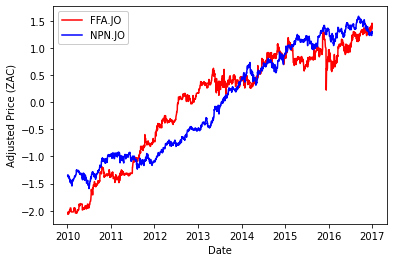

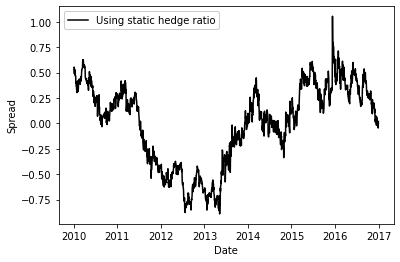

(array([[-2.05948899],
       [-2.05948899],
       [-2.04100759],
       ...,
       [ 1.42493987],
       [ 1.45689202],
       [ 1.37538946]]), array([[-1.34283596],
       [-1.33838093],
       [-1.34283596],
       ...,
       [ 1.26354062],
       [ 1.30676643],
       [ 1.28303525]]), Date
2010-01-04    0.549752
2010-01-05    0.554207
2010-01-06    0.532768
2010-01-07    0.488826
2010-01-08    0.536297
                ...   
2016-12-23    0.004656
2016-12-27    0.004656
2016-12-28   -0.045922
2016-12-29   -0.032059
2016-12-30    0.019107
Length: 1752, dtype: float64, Date
2017-01-03   -1.557899
2017-01-04   -1.582181
2017-01-05   -1.431839
2017-01-06   -1.375665
2017-01-09   -1.366361
                ...   
2019-12-23   -0.039090
2019-12-24   -0.001595
2019-12-27   -0.053611
2019-12-30   -0.024862
2019-12-31   -0.086132
Length: 752, dtype: float64, 0.9189600343743082, array([ 0.54975212,  0.55420714,  0.53276845, ..., -0.05361073,
       -0.02486232, -0.08613209]))


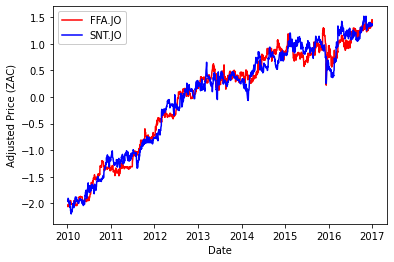

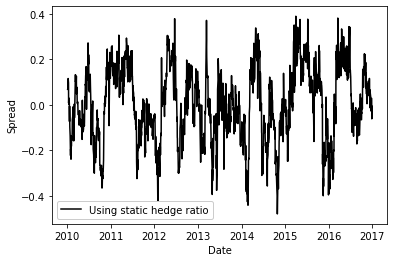

(array([[-2.05948899],
       [-2.05948899],
       [-2.04100759],
       ...,
       [ 1.42493987],
       [ 1.45689202],
       [ 1.37538946]]), array([[-1.96281341],
       [-1.96225969],
       [-1.90741238],
       ...,
       [ 1.34381314],
       [ 1.3800309 ],
       [ 1.35008918]]), Date
2010-01-04    0.068565
2010-01-05    0.069119
2010-01-06    0.105737
2010-01-07    0.087601
2010-01-08    0.115804
                ...   
2016-12-23    0.028086
2016-12-27    0.028086
2016-12-28   -0.061678
2016-12-29   -0.056976
2016-12-30   -0.006527
Length: 1752, dtype: float64, Date
2017-01-03   -0.692626
2017-01-04   -0.705283
2017-01-05   -0.600522
2017-01-06   -0.831103
2017-01-09   -0.868594
                ...   
2019-12-23   -0.787738
2019-12-24   -0.591584
2019-12-27   -0.795575
2019-12-30   -0.593490
2019-12-31   -0.685167
Length: 752, dtype: float64, 0.9863508914910948, array([ 0.06856539,  0.06911911,  0.10573728, ..., -0.79557497,
       -0.59348989, -0.68516652]))


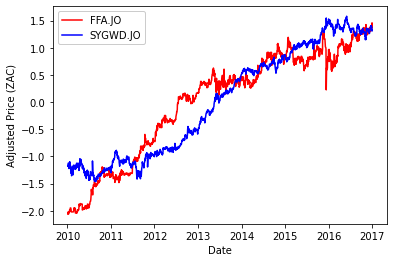

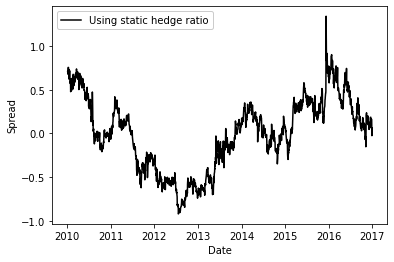

(array([[-2.05948899],
       [-2.05948899],
       [-2.04100759],
       ...,
       [ 1.42493987],
       [ 1.45689202],
       [ 1.37538946]]), array([[-1.17329909],
       [-1.18458834],
       [-1.16486547],
       ...,
       [ 1.34806979],
       [ 1.30558972],
       [ 1.32121505]]), Date
2010-01-04    0.708283
2010-01-05    0.696994
2010-01-06    0.699832
2010-01-07    0.680225
2010-01-08    0.755702
                ...   
2016-12-23    0.161013
2016-12-27    0.161013
2016-12-28    0.046222
2016-12-29   -0.025450
2016-12-30    0.064637
Length: 1752, dtype: float64, Date
2017-01-03   -0.322825
2017-01-04   -0.285458
2017-01-05   -0.174339
2017-01-06   -0.367830
2017-01-09   -0.395197
                ...   
2019-12-23    0.504564
2019-12-24    0.508237
2019-12-27    0.465629
2019-12-30    0.426670
2019-12-31    0.430763
Length: 752, dtype: float64, 0.9136160175480852, array([0.70828305, 0.69699379, 0.69983176, ..., 0.46562866, 0.42667037,
       0.43076303]))


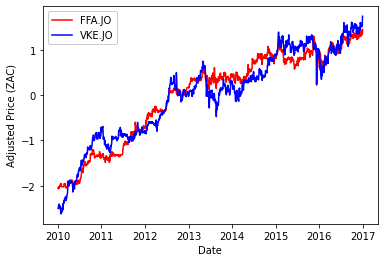

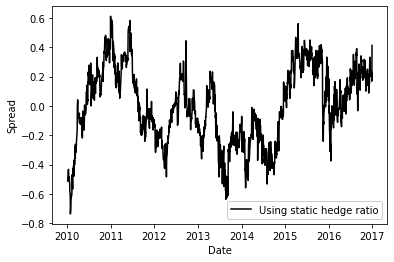

(array([[-2.05948899],
       [-2.05948899],
       [-2.04100759],
       ...,
       [ 1.42493987],
       [ 1.45689202],
       [ 1.37538946]]), array([[-2.49958607],
       [-2.47989405],
       [-2.47989405],
       ...,
       [ 1.54505535],
       [ 1.64436124],
       [ 1.74135348]]), Date
2010-01-04   -0.510484
2010-01-05   -0.490792
2010-01-06   -0.508641
2010-01-07   -0.510713
2010-01-08   -0.443907
                ...   
2016-12-23    0.228570
2016-12-27    0.228570
2016-12-28    0.168815
2016-12-29    0.237261
2016-12-30    0.412970
Length: 1752, dtype: float64, Date
2017-01-03   -0.888108
2017-01-04   -0.501714
2017-01-05   -0.451412
2017-01-06   -0.656288
2017-01-09   -0.841753
                ...   
2019-12-23   -0.040486
2019-12-24   -0.004216
2019-12-27    0.036502
2019-12-30    0.111673
2019-12-31    0.161646
Length: 752, dtype: float64, 0.9658232543119116, array([-0.51048371, -0.49079169, -0.50864145, ...,  0.03650235,
        0.11167278,  0.16164628]))


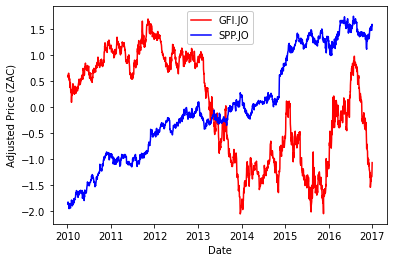

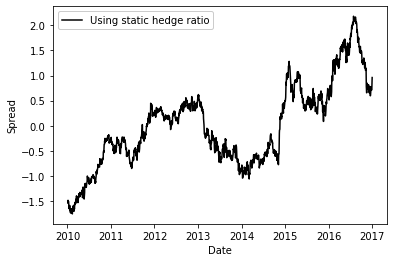

(array([[ 0.58111658],
       [ 0.57123406],
       [ 0.60664816],
       ...,
       [-1.29626624],
       [-1.14845793],
       [-1.07094882]]), array([[-1.86606027],
       [-1.83142793],
       [-1.82736157],
       ...,
       [ 1.55679975],
       [ 1.58607318],
       [ 1.56458388]]), Date
2010-01-04   -1.538164
2010-01-05   -1.509108
2010-01-06   -1.485059
2010-01-07   -1.519011
2010-01-08   -1.503664
                ...   
2016-12-23    0.715126
2016-12-27    0.715126
2016-12-28    0.825378
2016-12-29    0.938053
2016-12-30    0.960298
Length: 1752, dtype: float64, Date
2017-01-03   -0.455366
2017-01-04   -0.396299
2017-01-05   -0.321564
2017-01-06   -0.468753
2017-01-09   -0.446641
                ...   
2019-12-23    2.451125
2019-12-24    2.520866
2019-12-27    2.545739
2019-12-30    2.734847
2019-12-31    2.645090
Length: 752, dtype: float64, -0.5642524576056389, array([-1.53816381, -1.50910771, -1.48505885, ...,  2.54573858,
        2.73484652,  2.64508959]))


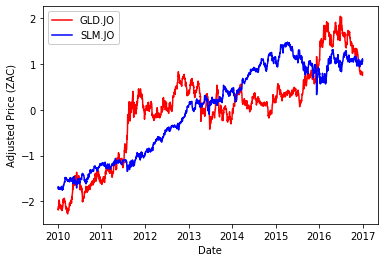

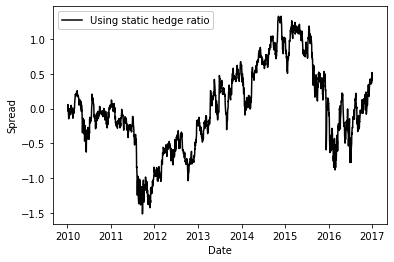

(array([[-2.17201876],
       [-2.18966289],
       [-2.15151686],
       ...,
       [ 0.78392525],
       [ 0.74988432],
       [ 0.82083993]]), array([[-1.72335595],
       [-1.67983977],
       [-1.70391017],
       ...,
       [ 1.06469356],
       [ 1.11328437],
       [ 1.06115687]]), Date
2010-01-04    0.000927
2010-01-05    0.058450
2010-01-06    0.004097
2010-01-07   -0.036870
2010-01-08   -0.008523
                ...   
2016-12-23    0.371230
2016-12-27    0.371230
2016-12-28    0.442365
2016-12-29    0.517980
2016-12-30    0.409523
Length: 1752, dtype: float64, Date
2017-01-03   -1.387616
2017-01-04   -1.207731
2017-01-05   -1.449413
2017-01-06   -1.352419
2017-01-09   -1.367378
                ...   
2019-12-23   -0.143766
2019-12-24   -0.178461
2019-12-27   -0.237631
2019-12-30   -0.194839
2019-12-31   -0.405565
Length: 752, dtype: float64, 0.793862020187278, array([ 0.00092725,  0.05845043,  0.00409736, ..., -0.23763121,
       -0.19483939, -0.40556494]))


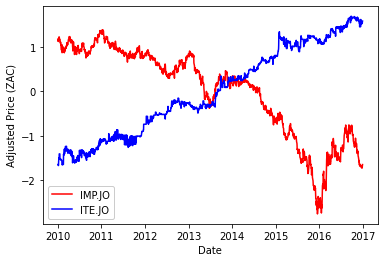

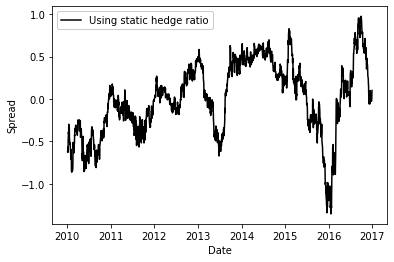

(array([[ 1.13504612],
       [ 1.19020692],
       [ 1.15645979],
       ...,
       [-1.67609932],
       [-1.6644221 ],
       [-1.64427173]]), array([[-1.64159127],
       [-1.64159127],
       [-1.66705324],
       ...,
       [ 1.55404087],
       [ 1.57604953],
       [ 1.58423749]]), Date
2010-01-04   -0.618070
2010-01-05   -0.568329
2010-01-06   -0.624222
2010-01-07   -0.627186
2010-01-08   -0.501487
                ...   
2016-12-23   -0.020842
2016-12-27   -0.020842
2016-12-28    0.042628
2016-12-29    0.075166
2016-12-30    0.101525
Length: 1752, dtype: float64, Date
2017-01-03   -0.592643
2017-01-04   -0.632484
2017-01-05   -0.702582
2017-01-06   -0.361937
2017-01-09   -0.716596
                ...   
2019-12-23    2.767544
2019-12-24    3.205125
2019-12-27    2.863730
2019-12-30    2.872312
2019-12-31    2.884287
Length: 752, dtype: float64, -0.9017442372474581, array([-0.61806997, -0.56832903, -0.62422229, ...,  2.86373022,
        2.87231233,  2.88428678]))


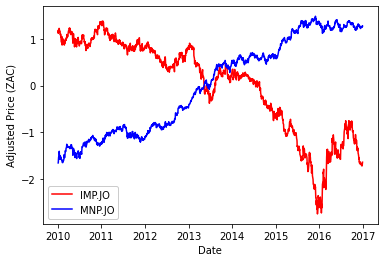

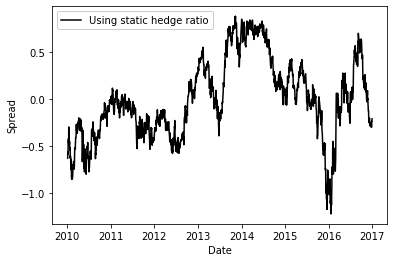

(array([[ 1.13504612],
       [ 1.19020692],
       [ 1.15645979],
       ...,
       [-1.67609932],
       [-1.6644221 ],
       [-1.64427173]]), array([[-1.65954178],
       [-1.64913081],
       [-1.61497045],
       ...,
       [ 1.2812219 ],
       [ 1.27007939],
       [ 1.27614468]]), Date
2010-01-04   -0.632367
2010-01-05   -0.572038
2010-01-06   -0.568417
2010-01-07   -0.590210
2010-01-08   -0.461903
                ...   
2016-12-23   -0.301214
2016-12-27   -0.301214
2016-12-28   -0.235585
2016-12-29   -0.236161
2016-12-30   -0.211860
Length: 1752, dtype: float64, Date
2017-01-03   -2.139621
2017-01-04   -2.288851
2017-01-05   -2.187906
2017-01-06   -2.151674
2017-01-09   -2.324869
                ...   
2019-12-23    2.384688
2019-12-24    2.486037
2019-12-27    2.618695
2019-12-30    2.714325
2019-12-31    2.609376
Length: 752, dtype: float64, -0.9049626976722362, array([-0.63236738, -0.57203794, -0.56841748, ...,  2.61869521,
        2.71432476,  2.6093762 ]))


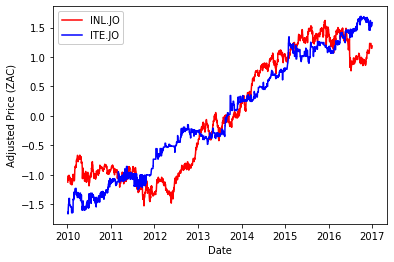

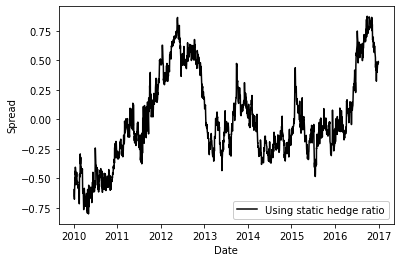

(array([[-1.12664664],
       [-1.06503506],
       [-1.09087343],
       ...,
       [ 1.16819907],
       [ 1.17004412],
       [ 1.18789082]]), array([[-1.64159127],
       [-1.64159127],
       [-1.66705324],
       ...,
       [ 1.55404087],
       [ 1.57604953],
       [ 1.58423749]]), Date
2010-01-04   -0.596311
2010-01-05   -0.653473
2010-01-06   -0.654963
2010-01-07   -0.677187
2010-01-08   -0.621968
                ...   
2016-12-23    0.466857
2016-12-27    0.466857
2016-12-28    0.470209
2016-12-29    0.490506
2016-12-30    0.482136
Length: 1752, dtype: float64, Date
2017-01-03    1.191697
2017-01-04    1.078776
2017-01-05    1.046430
2017-01-06    1.363926
2017-01-09    1.108983
                ...   
2019-12-23   -0.329609
2019-12-24    0.043038
2019-12-27   -0.342795
2019-12-30   -0.538470
2019-12-31   -0.151928
Length: 752, dtype: float64, 0.9277797078309061, array([-0.59631138, -0.65347335, -0.654963  , ..., -0.34279473,
       -0.53847043, -0.15192815]))


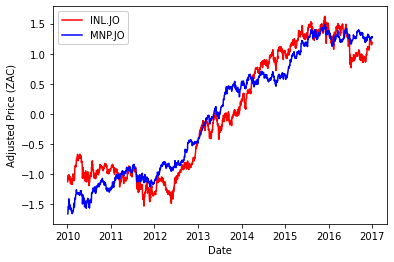

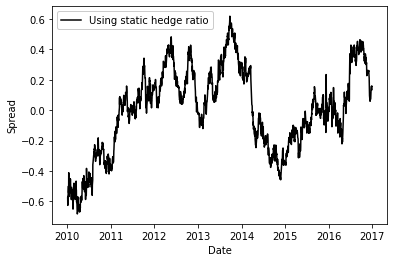

(array([[-1.12664664],
       [-1.06503506],
       [-1.09087343],
       ...,
       [ 1.16819907],
       [ 1.17004412],
       [ 1.18789082]]), array([[-1.65954178],
       [-1.64913081],
       [-1.61497045],
       ...,
       [ 1.2812219 ],
       [ 1.27007939],
       [ 1.27614468]]), Date
2010-01-04   -0.577940
2010-01-05   -0.626678
2010-01-06   -0.567712
2010-01-07   -0.610320
2010-01-08   -0.553343
                ...   
2016-12-23    0.155022
2016-12-27    0.155022
2016-12-28    0.159729
2016-12-29    0.146816
2016-12-30    0.135748
Length: 1752, dtype: float64, Date
2017-01-03   -0.289377
2017-01-04   -0.513197
2017-01-05   -0.370795
2017-01-06   -0.358611
2017-01-09   -0.428968
                ...   
2019-12-23   -0.754676
2019-12-24   -0.717335
2019-12-27   -0.630159
2019-12-30   -0.745275
2019-12-31   -0.463292
Length: 752, dtype: float64, 0.9600183736709651, array([-0.57794031, -0.62667758, -0.56771191, ..., -0.63015903,
       -0.7452752 , -0.46329248]))


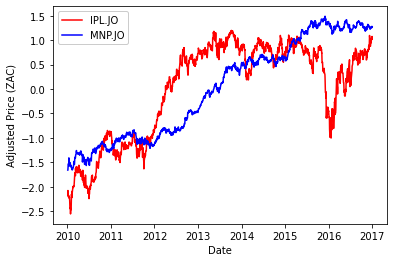

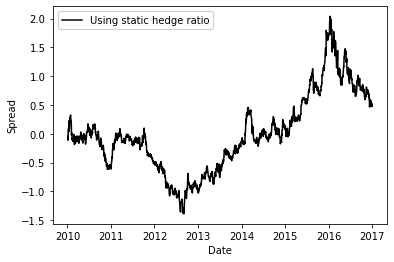

(array([[-2.18034194],
       [-2.07754918],
       [-2.11686913],
       ...,
       [ 1.06423891],
       [ 1.07597603],
       [ 1.02875912]]), array([[-1.65954178],
       [-1.64913081],
       [-1.61497045],
       ...,
       [ 1.2812219 ],
       [ 1.27007939],
       [ 1.27614468]]), Date
2010-01-04   -0.047483
2010-01-05   -0.113073
2010-01-06   -0.049841
2010-01-07    0.004085
2010-01-08    0.067846
                ...   
2016-12-23    0.508159
2016-12-27    0.508159
2016-12-28    0.494366
2016-12-29    0.474545
2016-12-30    0.515521
Length: 1752, dtype: float64, Date
2017-01-03   -2.708553
2017-01-04   -2.915818
2017-01-05   -2.865354
2017-01-06   -2.821538
2017-01-09   -2.987770
                ...   
2019-12-23    1.188733
2019-12-24    1.129289
2019-12-27    1.288348
2019-12-30    1.348043
2019-12-31    1.290370
Length: 752, dtype: float64, 0.7393605829699564, array([-0.04748289, -0.11307283, -0.04984085, ...,  1.28834786,
        1.34804273,  1.29036956]))


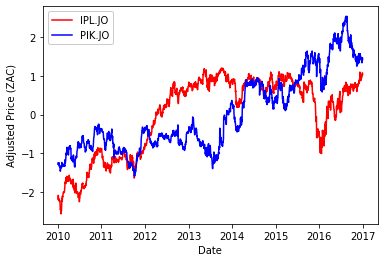

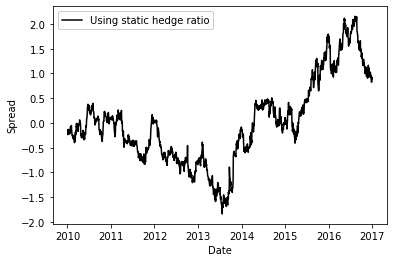

(array([[-2.18034194],
       [-2.07754918],
       [-2.11686913],
       ...,
       [ 1.06423891],
       [ 1.07597603],
       [ 1.02875912]]), array([[-1.24350333],
       [-1.29087507],
       [-1.2676509 ],
       ...,
       [ 1.43762267],
       [ 1.46703131],
       [ 1.41880203]]), Date
2010-01-04   -0.137549
2010-01-05   -0.237061
2010-01-06   -0.193892
2010-01-07   -0.137369
2010-01-08   -0.146330
                ...   
2016-12-23    0.825550
2016-12-27    0.825550
2016-12-28    0.897799
2016-12-29    0.921254
2016-12-30    0.896975
Length: 1752, dtype: float64, Date
2017-01-03   -1.301109
2017-01-04   -1.413471
2017-01-05   -1.462268
2017-01-06   -1.300482
2017-01-09   -1.097427
                ...   
2019-12-23    0.629423
2019-12-24    0.510287
2019-12-27    0.598812
2019-12-30    0.771010
2019-12-31    0.611040
Length: 752, dtype: float64, 0.50723909433193, array([-0.13754866, -0.23706091, -0.19389212, ...,  0.59881239,
        0.77101   ,  0.61103991]))


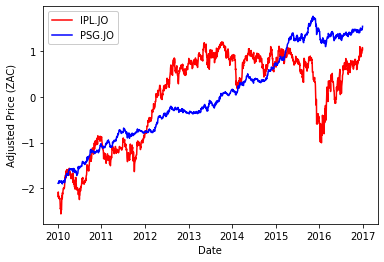

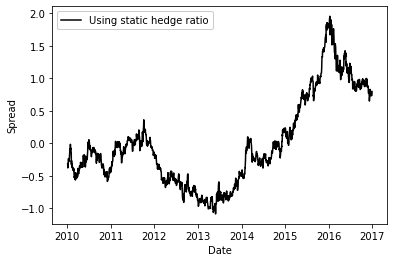

(array([[-2.18034194],
       [-2.07754918],
       [-2.11686913],
       ...,
       [ 1.06423891],
       [ 1.07597603],
       [ 1.02875912]]), array([[-1.88672201],
       [-1.8782848 ],
       [-1.88109061],
       ...,
       [ 1.5021702 ],
       [ 1.51374452],
       [ 1.53922668]]), Date
2010-01-04   -0.311255
2010-01-05   -0.377094
2010-01-06   -0.351488
2010-01-07   -0.313824
2010-01-08   -0.315327
                ...   
2016-12-23    0.734815
2016-12-27    0.734815
2016-12-28    0.733175
2016-12-29    0.736268
2016-12-30    0.795868
Length: 1752, dtype: float64, Date
2017-01-03   -2.478763
2017-01-04   -2.400633
2017-01-05   -2.436413
2017-01-06   -2.373786
2017-01-09   -2.533926
                ...   
2019-12-23    2.080857
2019-12-24    2.030045
2019-12-27    2.112106
2019-12-30    2.219739
2019-12-31    2.145160
Length: 752, dtype: float64, 0.7225778944320204, array([-0.31125512, -0.37709369, -0.35148777, ...,  2.11210618,
        2.21973944,  2.14515964]))


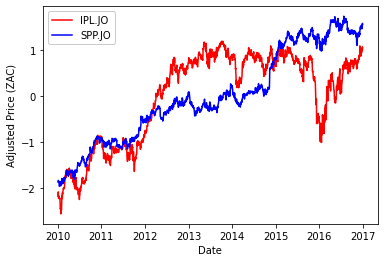

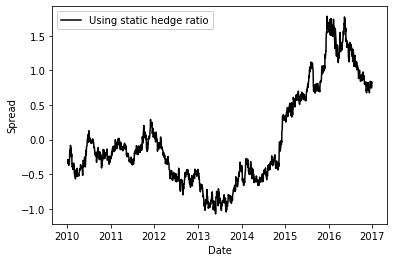

(array([[-2.18034194],
       [-2.07754918],
       [-2.11686913],
       ...,
       [ 1.06423891],
       [ 1.07597603],
       [ 1.02875912]]), array([[-1.86606027],
       [-1.83142793],
       [-1.82736157],
       ...,
       [ 1.55679975],
       [ 1.58607318],
       [ 1.56458388]]), Date
2010-01-04   -0.303434
2010-01-05   -0.342472
2010-01-06   -0.310225
2010-01-07   -0.291958
2010-01-08   -0.297165
                ...   
2016-12-23    0.746867
2016-12-27    0.746867
2016-12-28    0.794072
2016-12-29    0.814933
2016-12-30    0.827284
Length: 1752, dtype: float64, Date
2017-01-03   -0.368627
2017-01-04   -0.349500
2017-01-05   -0.329471
2017-01-06   -0.452920
2017-01-09   -0.413201
                ...   
2019-12-23    2.165268
2019-12-24    2.067448
2019-12-27    2.073942
2019-12-30    2.229369
2019-12-31    2.115195
Length: 752, dtype: float64, 0.7166887877308886, array([-0.30343364, -0.34247173, -0.31022519, ...,  2.07394201,
        2.22936903,  2.11519517]))


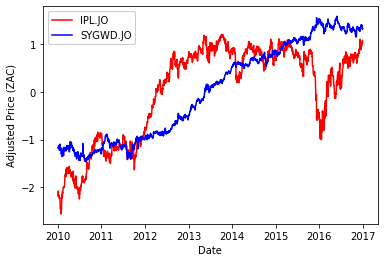

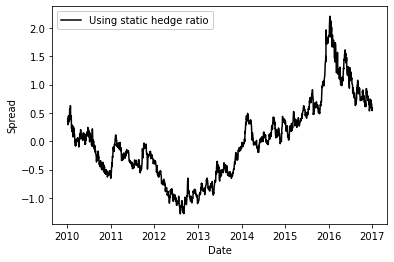

(array([[-2.18034194],
       [-2.07754918],
       [-2.11686913],
       ...,
       [ 1.06423891],
       [ 1.07597603],
       [ 1.02875912]]), array([[-1.17329909],
       [-1.18458834],
       [-1.16486547],
       ...,
       [ 1.34806979],
       [ 1.30558972],
       [ 1.32121505]]), Date
2010-01-04    0.376176
2010-01-05    0.291836
2010-01-06    0.339502
2010-01-07    0.382053
2010-01-08    0.411292
                ...   
2016-12-23    0.660002
2016-12-27    0.660002
2016-12-28    0.591761
2016-12-29    0.540940
2016-12-30    0.590120
Length: 1752, dtype: float64, Date
2017-01-03   -1.884412
2017-01-04   -1.900526
2017-01-05   -1.898585
2017-01-06   -1.839397
2017-01-09   -1.870675
                ...   
2019-12-23    2.589951
2019-12-24    2.508603
2019-12-27    2.532557
2019-12-30    2.497147
2019-12-31    2.468647
Length: 752, dtype: float64, 0.710656726020741, array([0.37617558, 0.29183596, 0.33950182, ..., 2.53255659, 2.49714738,
       2.46864708]))


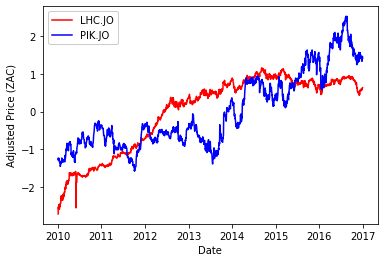

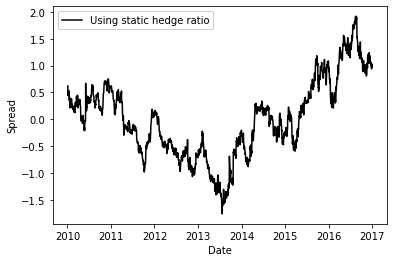

(array([[-2.71757881],
       [-2.52803478],
       [-2.52803478],
       ...,
       [ 0.61574974],
       [ 0.64026425],
       [ 0.63721632]]), array([[-1.24350333],
       [-1.29087507],
       [-1.2676509 ],
       ...,
       [ 1.43762267],
       [ 1.46703131],
       [ 1.41880203]]), Date
2010-01-04    0.620225
2010-01-05    0.442863
2010-01-06    0.466087
2010-01-07    0.532203
2010-01-08    0.532203
                ...   
2016-12-23    0.942583
2016-12-27    0.942583
2016-12-28    1.015339
2016-12-29    1.027935
2016-12-30    0.981796
Length: 1752, dtype: float64, Date
2017-01-03   -2.111256
2017-01-04   -2.200906
2017-01-05   -2.315518
2017-01-06   -2.262449
2017-01-09   -1.914604
                ...   
2019-12-23   -0.088610
2019-12-24   -0.152727
2019-12-27   -0.216282
2019-12-30   -0.088237
2019-12-31   -0.106695
Length: 752, dtype: float64, 0.6858046750163785, array([ 0.62022492,  0.442863  ,  0.46608717, ..., -0.21628213,
       -0.08823712, -0.10669498]))


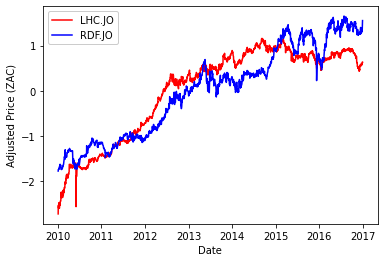

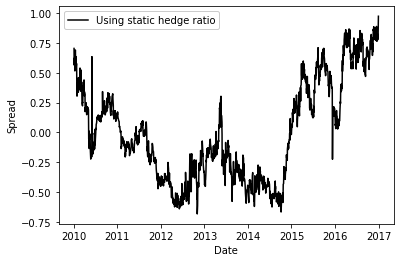

(array([[-2.71757881],
       [-2.52803478],
       [-2.52803478],
       ...,
       [ 0.61574974],
       [ 0.64026425],
       [ 0.63721632]]), array([[-1.77108541],
       [-1.73765421],
       [-1.73765421],
       ...,
       [ 1.42406581],
       [ 1.48038871],
       [ 1.55406184]]), Date
2010-01-04    0.704062
2010-01-05    0.564858
2010-01-06    0.564858
2010-01-07    0.620595
2010-01-08    0.625344
                ...   
2016-12-23    0.778471
2016-12-27    0.778471
2016-12-28    0.863246
2016-12-29    0.897241
2016-12-30    0.973691
Length: 1752, dtype: float64, Date
2017-01-03   -1.290282
2017-01-04   -1.562283
2017-01-05   -1.852694
2017-01-06   -1.625438
2017-01-09   -1.549028
                ...   
2019-12-23   -1.987943
2019-12-24   -2.137720
2019-12-27   -2.215918
2019-12-30   -2.120633
2019-12-31   -1.971831
Length: 752, dtype: float64, 0.910791471448582, array([ 0.7040622 ,  0.56485831,  0.56485831, ..., -2.21591812,
       -2.12063337, -1.97183115]))


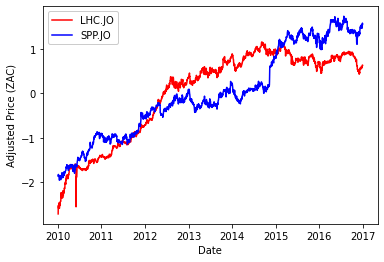

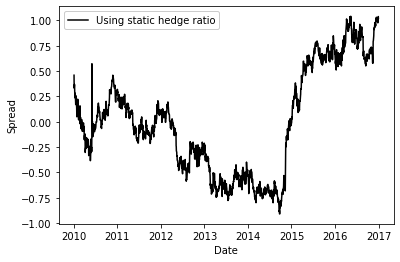

(array([[-2.71757881],
       [-2.52803478],
       [-2.52803478],
       ...,
       [ 0.61574974],
       [ 0.64026425],
       [ 0.63721632]]), array([[-1.86606027],
       [-1.83142793],
       [-1.82736157],
       ...,
       [ 1.55679975],
       [ 1.58607318],
       [ 1.56458388]]), Date
2010-01-04    0.459352
2010-01-05    0.331793
2010-01-06    0.335860
2010-01-07    0.360747
2010-01-08    0.368201
                ...   
2016-12-23    0.977756
2016-12-27    0.977756
2016-12-28    1.029907
2016-12-29    1.038204
2016-12-30    1.019322
Length: 1752, dtype: float64, Date
2017-01-03   -1.329220
2017-01-04   -1.278931
2017-01-05   -1.344024
2017-01-06   -1.603637
2017-01-09   -1.382799
                ...   
2019-12-23    1.166296
2019-12-24    1.143738
2019-12-27    0.955663
2019-12-30    1.057849
2019-12-31    1.117263
Length: 752, dtype: float64, 0.8556928350198723, array([0.45935245, 0.33179332, 0.33585968, ..., 0.95566305, 1.05784854,
       1.11726335]))


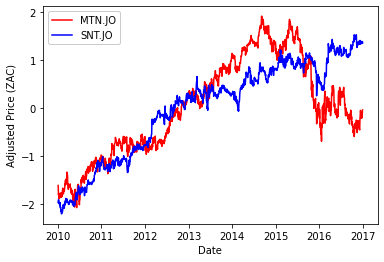

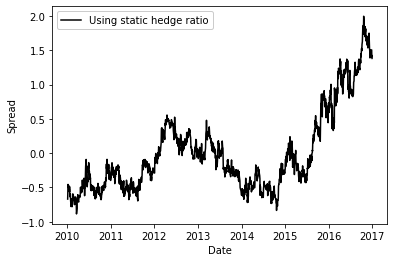

(array([[-1.60854722],
       [-1.70201561],
       [-1.72465938],
       ...,
       [-0.07661755],
       [-0.05624886],
       [-0.03998937]]), array([[-1.96281341],
       [-1.96225969],
       [-1.90741238],
       ...,
       [ 1.34381314],
       [ 1.3800309 ],
       [ 1.35008918]]), Date
2010-01-04   -0.669668
2010-01-05   -0.593973
2010-01-06   -0.520922
2010-01-07   -0.455601
2010-01-08   -0.493539
                ...   
2016-12-23    1.506252
2016-12-27    1.506252
2016-12-28    1.405408
2016-12-29    1.425251
2016-12-30    1.382237
Length: 1752, dtype: float64, Date
2017-01-03   -2.529359
2017-01-04   -2.715802
2017-01-05   -2.647907
2017-01-06   -2.808990
2017-01-09   -2.769958
                ...   
2019-12-23    1.499537
2019-12-24    1.737884
2019-12-27    1.562408
2019-12-30    1.831225
2019-12-31    1.757989
Length: 752, dtype: float64, 0.8039210762300073, array([-0.6696684 , -0.59397347, -0.52092236, ...,  1.56240838,
        1.83122543,  1.75798949]))


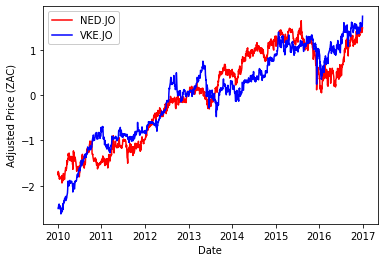

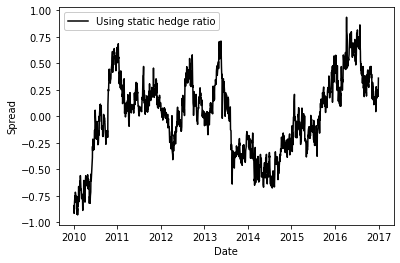

(array([[-1.75158119],
       [-1.68199997],
       [-1.76506452],
       ...,
       [ 1.457344  ],
       [ 1.47957801],
       [ 1.48372186]]), array([[-2.49958607],
       [-2.47989405],
       [-2.47989405],
       ...,
       [ 1.54505535],
       [ 1.64436124],
       [ 1.74135348]]), Date
2010-01-04   -0.869857
2010-01-05   -0.914906
2010-01-06   -0.837620
2010-01-07   -0.876608
2010-01-08   -0.808131
                ...   
2016-12-23    0.216065
2016-12-27    0.216065
2016-12-28    0.189094
2016-12-29    0.267713
2016-12-30    0.360850
Length: 1752, dtype: float64, Date
2017-01-03   -1.300761
2017-01-04   -0.916748
2017-01-05   -0.799916
2017-01-06   -0.787529
2017-01-09   -1.094890
                ...   
2019-12-23    1.601459
2019-12-24    1.607829
2019-12-27    1.683701
2019-12-30    1.688395
2019-12-31    1.818351
Length: 752, dtype: float64, 0.9304330267707543, array([-0.86985708, -0.91490572, -0.83761972, ...,  1.68370059,
        1.68839514,  1.81835112]))


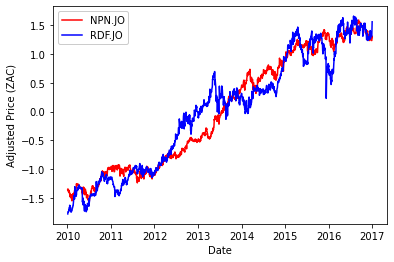

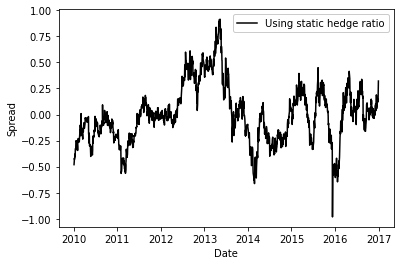

(array([[-1.34283596],
       [-1.33838093],
       [-1.34283596],
       ...,
       [ 1.26354062],
       [ 1.30676643],
       [ 1.28303525]]), array([[-1.77108541],
       [-1.73765421],
       [-1.73765421],
       ...,
       [ 1.42406581],
       [ 1.48038871],
       [ 1.55406184]]), Date
2010-01-04   -0.481155
2010-01-05   -0.452004
2010-01-06   -0.447724
2010-01-07   -0.421744
2010-01-08   -0.430050
                ...   
2016-12-23    0.123265
2016-12-27    0.123265
2016-12-28    0.210307
2016-12-29    0.225107
2016-12-30    0.321576
Length: 1752, dtype: float64, Date
2017-01-03    2.783203
2017-01-04    2.555601
2017-01-05    2.314132
2017-01-06    2.387748
2017-01-09    2.266637
                ...   
2019-12-23   -2.995747
2019-12-24   -3.173488
2019-12-27   -3.063313
2019-12-30   -2.940723
2019-12-31   -2.889048
Length: 752, dtype: float64, 0.9606013578546163, array([-0.48115537, -0.45200368, -0.44772417, ..., -3.06331312,
       -2.94072285, -2.88904752]))


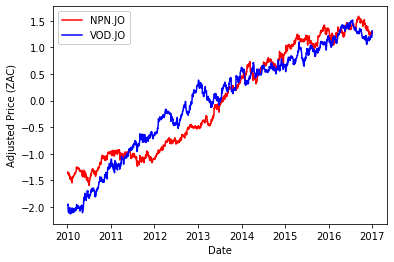

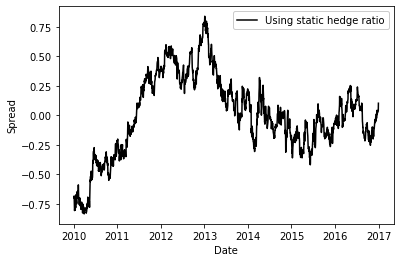

(array([[-1.34283596],
       [-1.33838093],
       [-1.34283596],
       ...,
       [ 1.26354062],
       [ 1.30676643],
       [ 1.28303525]]), array([[-1.96447719],
       [-1.94427386],
       [-2.00707562],
       ...,
       [ 1.22682169],
       [ 1.27261432],
       [ 1.31147684]]), Date
2010-01-04   -0.699739
2010-01-05   -0.683732
2010-01-06   -0.742338
2010-01-07   -0.788240
2010-01-08   -0.807874
                ...   
2016-12-23    0.030277
2016-12-27    0.030277
2016-12-28    0.036767
2016-12-29    0.041848
2016-12-30    0.103062
Length: 1752, dtype: float64, Date
2017-01-03    2.689761
2017-01-04    2.842875
2017-01-05    2.777831
2017-01-06    2.462744
2017-01-09    2.560680
                ...   
2019-12-23   -1.949941
2019-12-24   -1.954360
2019-12-27   -1.943679
2019-12-30   -1.961986
2019-12-31   -2.011568
Length: 752, dtype: float64, 0.9418409298080868, array([-0.69973932, -0.68373192, -0.74233775, ..., -1.94367876,
       -1.96198612, -2.01156808]))


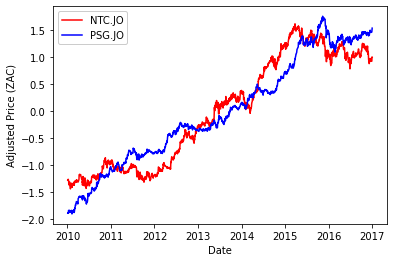

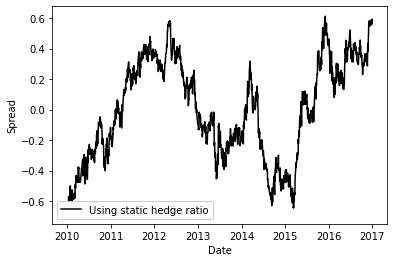

(array([[-1.27628649],
       [-1.27309164],
       [-1.2651237 ],
       ...,
       [ 0.97783959],
       [ 1.00670147],
       [ 1.00123346]]), array([[-1.88672201],
       [-1.8782848 ],
       [-1.88109061],
       ...,
       [ 1.5021702 ],
       [ 1.51374452],
       [ 1.53922668]]), Date
2010-01-04   -0.677972
2010-01-05   -0.672561
2010-01-06   -0.682913
2010-01-07   -0.677767
2010-01-08   -0.684621
                ...   
2016-12-23    0.588225
2016-12-27    0.588225
2016-12-28    0.576075
2016-12-29    0.560314
2016-12-30    0.590975
Length: 1752, dtype: float64, Date
2017-01-03   -3.219752
2017-01-04   -3.172925
2017-01-05   -3.221664
2017-01-06   -3.169034
2017-01-09   -3.334434
                ...   
2019-12-23    2.144952
2019-12-24    2.142054
2019-12-27    2.155347
2019-12-30    2.212834
2019-12-31    2.208937
Length: 752, dtype: float64, 0.9470834319709597, array([-0.67797222, -0.6725608 , -0.68291291, ...,  2.15534658,
        2.21283376,  2.20893711]))


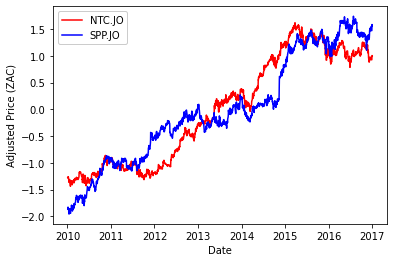

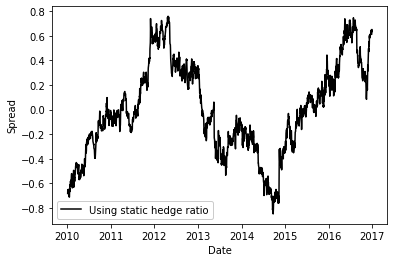

(array([[-1.27628649],
       [-1.27309164],
       [-1.2651237 ],
       ...,
       [ 0.97783959],
       [ 1.00670147],
       [ 1.00123346]]), array([[-1.86606027],
       [-1.83142793],
       [-1.82736157],
       ...,
       [ 1.55679975],
       [ 1.58607318],
       [ 1.56458388]]), Date
2010-01-04   -0.681659
2010-01-05   -0.649992
2010-01-06   -0.653320
2010-01-07   -0.667469
2010-01-08   -0.677766
                ...   
2016-12-23    0.612007
2016-12-27    0.612007
2016-12-28    0.649359
2016-12-29    0.651849
2016-12-30    0.635434
Length: 1752, dtype: float64, Date
2017-01-03   -1.089494
2017-01-04   -1.100746
2017-01-05   -1.093726
2017-01-06   -1.227025
2017-01-09   -1.192411
                ...   
2019-12-23    2.217413
2019-12-24    2.167225
2019-12-27    2.105838
2019-12-30    2.212320
2019-12-31    2.167097
Length: 752, dtype: float64, 0.928005414537631, array([-0.68165949, -0.64999199, -0.65331992, ...,  2.10583783,
        2.2123201 ,  2.16709743]))


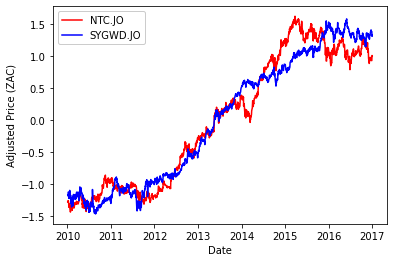

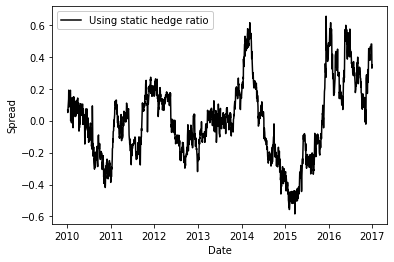

(array([[-1.27628649],
       [-1.27309164],
       [-1.2651237 ],
       ...,
       [ 0.97783959],
       [ 1.00670147],
       [ 1.00123346]]), array([[-1.17329909],
       [-1.18458834],
       [-1.16486547],
       ...,
       [ 1.34806979],
       [ 1.30558972],
       [ 1.32121505]]), Date
2010-01-04    0.065283
2010-01-05    0.050893
2010-01-06    0.062884
2010-01-07    0.074014
2010-01-08    0.097243
                ...   
2016-12-23    0.479661
2016-12-27    0.479661
2016-12-28    0.399118
2016-12-29    0.328629
2016-12-30    0.349560
Length: 1752, dtype: float64, Date
2017-01-03   -2.661531
2017-01-04   -2.710722
2017-01-05   -2.720993
2017-01-06   -2.671867
2017-01-09   -2.708698
                ...   
2019-12-23    2.692226
2019-12-24    2.657626
2019-12-27    2.612823
2019-12-30    2.525374
2019-12-31    2.570359
Length: 752, dtype: float64, 0.9704576555086452, array([0.06528291, 0.05089319, 0.06288351, ..., 2.61282292, 2.52537361,
       2.57035876]))


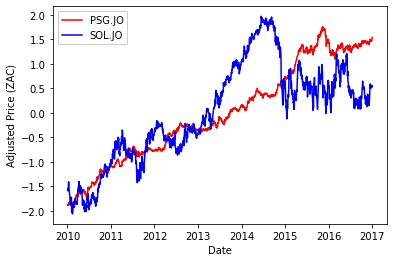

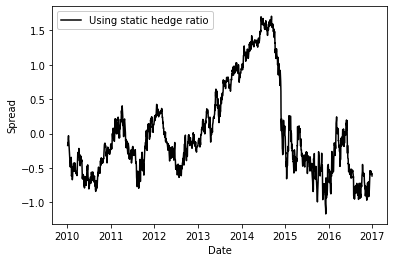

(array([[-1.88672201],
       [-1.8782848 ],
       [-1.88109061],
       ...,
       [ 1.5021702 ],
       [ 1.51374452],
       [ 1.53922668]]), array([[-1.58999033],
       [-1.56290951],
       [-1.54312849],
       ...,
       [ 0.55126109],
       [ 0.5581571 ],
       [ 0.54070181]]), Date
2010-01-04   -0.172578
2010-01-05   -0.151836
2010-01-06   -0.129947
2010-01-07   -0.145258
2010-01-08   -0.108278
                ...   
2016-12-23   -0.586845
2016-12-27   -0.586845
2016-12-28   -0.577254
2016-12-29   -0.579053
2016-12-30   -0.615652
Length: 1752, dtype: float64, Date
2017-01-03    1.382205
2017-01-04    1.275300
2017-01-05    1.253490
2017-01-06    1.266860
2017-01-09    1.348329
                ...   
2019-12-23   -2.164224
2019-12-24   -2.177929
2019-12-27   -2.138275
2019-12-30   -2.278655
2019-12-31   -2.326659
Length: 752, dtype: float64, 0.7512564814387719, array([-0.17257819, -0.15183588, -0.12994698, ..., -2.13827474,
       -2.27865495, -2.32665883]))


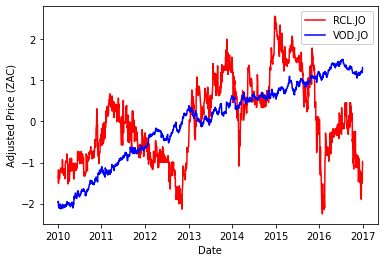

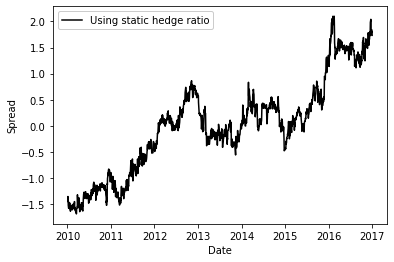

(array([[-1.18576645],
       [-1.35529387],
       [-1.34939534],
       ...,
       [-1.3079112 ],
       [-1.23260922],
       [-0.97375995]]), array([[-1.96447719],
       [-1.94427386],
       [-2.00707562],
       ...,
       [ 1.22682169],
       [ 1.27261432],
       [ 1.31147684]]), Date
2010-01-04   -1.449237
2010-01-05   -1.355371
2010-01-06   -1.420736
2010-01-07   -1.424944
2010-01-08   -1.521936
                ...   
2016-12-23    1.840504
2016-12-27    1.840504
2016-12-28    1.795136
2016-12-29    1.808208
2016-12-30    1.734595
Length: 1752, dtype: float64, Date
2017-01-03    0.582505
2017-01-04    0.554891
2017-01-05    0.655440
2017-01-06    0.503121
2017-01-09    0.619240
                ...   
2019-12-23   -0.269047
2019-12-24   -0.353211
2019-12-27   -0.356361
2019-12-30   -0.329377
2019-12-31   -0.425746
Length: 752, dtype: float64, 0.43452049307911167, array([-1.44923737, -1.3553709 , -1.42073569, ..., -0.35636054,
       -0.3293771 , -0.42574643]))


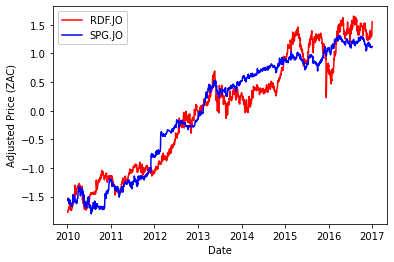

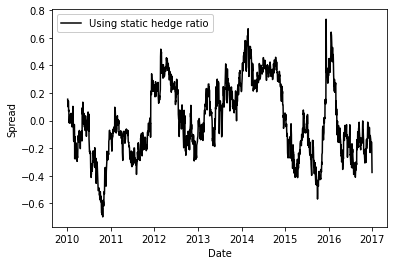

(array([[-1.77108541],
       [-1.73765421],
       [-1.73765421],
       ...,
       [ 1.42406581],
       [ 1.48038871],
       [ 1.55406184]]), array([[-1.5537516 ],
       [-1.5537516 ],
       [-1.53110454],
       ...,
       [ 1.11374091],
       [ 1.11759878],
       [ 1.122599  ]]), Date
2010-01-04    0.154724
2010-01-05    0.122474
2010-01-06    0.145121
2010-01-07    0.099476
2010-01-08    0.140540
                ...   
2016-12-23   -0.157025
2016-12-27   -0.157025
2016-12-28   -0.259982
2016-12-29   -0.310456
2016-12-30   -0.376525
Length: 1752, dtype: float64, Date
2017-01-03    0.509651
2017-01-04    0.828715
2017-01-05    0.991582
2017-01-06    0.628046
2017-01-09    0.663639
                ...   
2019-12-23    0.065404
2019-12-24    0.103008
2019-12-27    0.158941
2019-12-30   -0.166092
2019-12-31   -0.184433
Length: 752, dtype: float64, 0.9646487933419168, array([ 0.15472381,  0.12247445,  0.1451215 , ...,  0.1589412 ,
       -0.16609159, -0.18443294]))


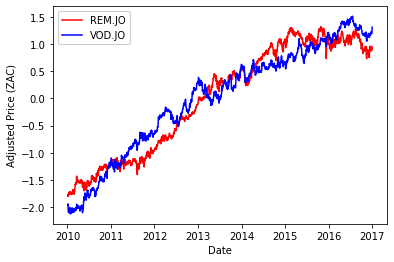

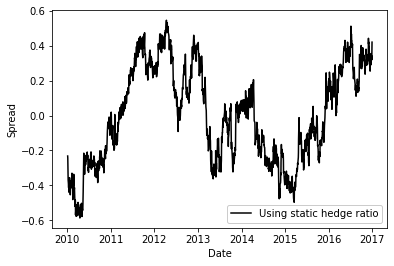

(array([[-1.80085606],
       [-1.76796425],
       [-1.77709543],
       ...,
       [ 0.94418703],
       [ 0.94620435],
       [ 0.92686496]]), array([[-1.96447719],
       [-1.94427386],
       [-2.00707562],
       ...,
       [ 1.22682169],
       [ 1.27261432],
       [ 1.31147684]]), Date
2010-01-04   -0.231615
2010-01-05   -0.243061
2010-01-06   -0.297077
2010-01-07   -0.349045
2010-01-08   -0.369409
                ...   
2016-12-23    0.342212
2016-12-27    0.342212
2016-12-28    0.318284
2016-12-29    0.362135
2016-12-30    0.419607
Length: 1752, dtype: float64, Date
2017-01-03   -0.638426
2017-01-04   -0.581910
2017-01-05   -0.426176
2017-01-06   -0.676124
2017-01-09   -0.389533
                ...   
2019-12-23   -0.985873
2019-12-24   -0.911182
2019-12-27   -1.040927
2019-12-30   -1.122296
2019-12-31   -1.191364
Length: 752, dtype: float64, 0.9622437498561347, array([-0.2316147 , -0.24306132, -0.29707665, ..., -1.04092678,
       -1.12229575, -1.19136376]))


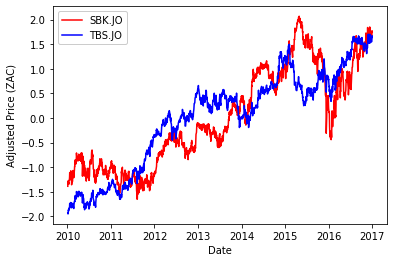

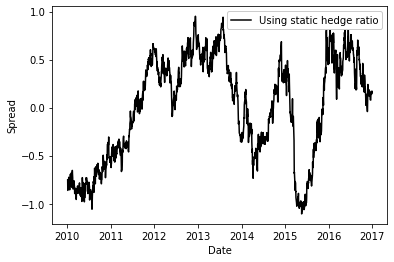

(array([[-1.38981456],
       [-1.28246614],
       [-1.28896528],
       ...,
       [ 1.76168504],
       [ 1.77407904],
       [ 1.74510656]]), array([[-1.92801592],
       [-1.94614605],
       [-1.95189347],
       ...,
       [ 1.63287239],
       [ 1.67311074],
       [ 1.63991314]]), Date
2010-01-04   -0.752329
2010-01-05   -0.861269
2010-01-06   -0.861518
2010-01-07   -0.816758
2010-01-08   -0.750277
                ...   
2016-12-23    0.146942
2016-12-27    0.146942
2016-12-28    0.142609
2016-12-29    0.172363
2016-12-30    0.163674
Length: 1752, dtype: float64, Date
2017-01-03    2.065383
2017-01-04    2.059516
2017-01-05    2.181642
2017-01-06    2.188811
2017-01-09    2.145457
                ...   
2019-12-23   -1.595058
2019-12-24   -1.524384
2019-12-27   -1.573788
2019-12-30   -1.615657
2019-12-31   -1.643147
Length: 752, dtype: float64, 0.8459305949555971, array([-0.75232926, -0.86126871, -0.86151831, ..., -1.5737883 ,
       -1.61565672, -1.64314687]))


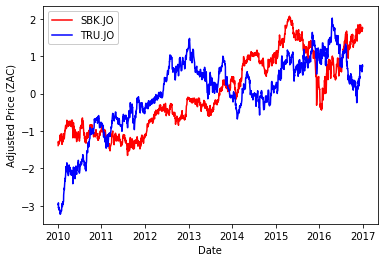

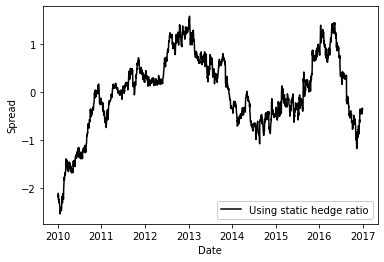

(array([[-1.38981456],
       [-1.28246614],
       [-1.28896528],
       ...,
       [ 1.76168504],
       [ 1.77407904],
       [ 1.74510656]]), array([[-2.96970395],
       [-2.98283053],
       [-2.92408663],
       ...,
       [ 0.70722261],
       [ 0.77011922],
       [ 0.72795054]]), Date
2010-01-04   -2.103807
2010-01-05   -2.183815
2010-01-06   -2.121022
2010-01-07   -2.238680
2010-01-08   -2.209778
                ...   
2016-12-23   -0.449311
2016-12-27   -0.449311
2016-12-28   -0.390361
2016-12-29   -0.335187
2016-12-30   -0.359304
Length: 1752, dtype: float64, Date
2017-01-03    0.749365
2017-01-04    0.758615
2017-01-05    0.627496
2017-01-06    0.537644
2017-01-09    0.487117
                ...   
2019-12-23   -2.371702
2019-12-24   -2.392495
2019-12-27   -2.320933
2019-12-30   -2.312589
2019-12-31   -2.435050
Length: 752, dtype: float64, 0.6230307451214868, array([-2.10380676, -2.1838147 , -2.12102164, ..., -2.32093317,
       -2.31258895, -2.43504999]))


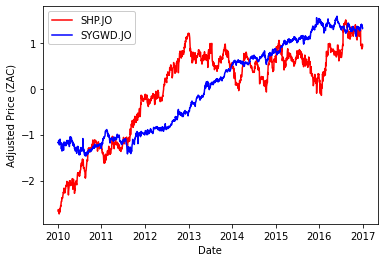

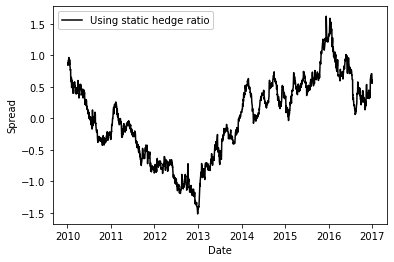

(array([[-2.66718469],
       [-2.63092184],
       [-2.64055149],
       ...,
       [ 0.93474207],
       [ 0.97142843],
       [ 0.91670629]]), array([[-1.17329909],
       [-1.18458834],
       [-1.16486547],
       ...,
       [ 1.34806979],
       [ 1.30558972],
       [ 1.32121505]]), Date
2010-01-04    0.882795
2010-01-05    0.843551
2010-01-06    0.870697
2010-01-07    0.879068
2010-01-08    0.920861
                ...   
2016-12-23    0.708221
2016-12-27    0.708221
2016-12-28    0.627491
2016-12-29    0.556730
2016-12-30    0.614539
Length: 1752, dtype: float64, Date
2017-01-03   -0.961849
2017-01-04   -0.856661
2017-01-05   -0.864917
2017-01-06   -0.783176
2017-01-09   -0.839979
                ...   
2019-12-23    3.195409
2019-12-24    3.165196
2019-12-27    3.190400
2019-12-30    3.175667
2019-12-31    3.147989
Length: 752, dtype: float64, 0.770885530400194, array([0.882795  , 0.84355124, 0.87069747, ..., 3.19040047, 3.17566686,
       3.14798871]))


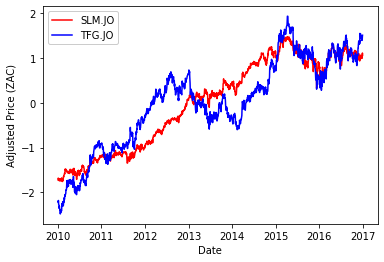

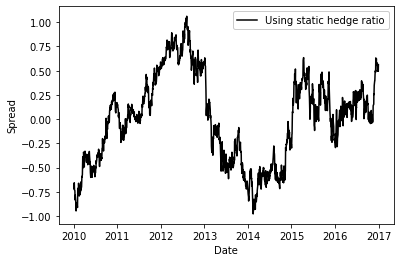

(array([[-1.72335595],
       [-1.67983977],
       [-1.70391017],
       ...,
       [ 1.06469356],
       [ 1.11328437],
       [ 1.06115687]]), array([[-2.20410286],
       [-2.22267884],
       [-2.1798413 ],
       ...,
       [ 1.46724558],
       [ 1.48916423],
       [ 1.50982627]]), Date
2010-01-04   -0.664915
2010-01-05   -0.722357
2010-01-06   -0.658021
2010-01-07   -0.709527
2010-01-08   -0.731574
                ...   
2016-12-23    0.507405
2016-12-27    0.507405
2016-12-28    0.516332
2016-12-29    0.494852
2016-12-30    0.562071
Length: 1752, dtype: float64, Date
2017-01-03    1.018910
2017-01-04    0.872895
2017-01-05    0.945539
2017-01-06    0.932360
2017-01-09    0.883240
                ...   
2019-12-23   -1.196656
2019-12-24   -1.265446
2019-12-27   -1.148995
2019-12-30   -1.155548
2019-12-31   -1.068753
Length: 752, dtype: float64, 0.893134043658758, array([-0.66491499, -0.72235675, -0.65802112, ..., -1.1489946 ,
       -1.15554806, -1.06875253]))


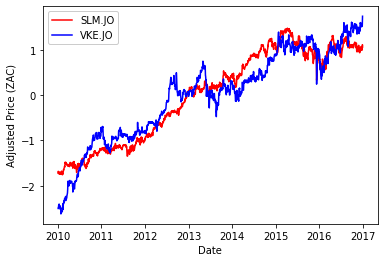

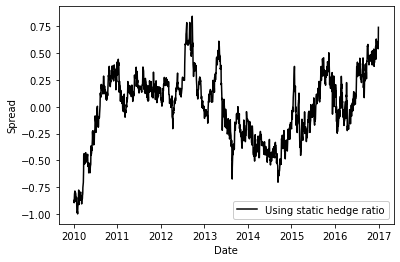

(array([[-1.72335595],
       [-1.67983977],
       [-1.70391017],
       ...,
       [ 1.06469356],
       [ 1.11328437],
       [ 1.06115687]]), array([[-2.49958607],
       [-2.47989405],
       [-2.47989405],
       ...,
       [ 1.54505535],
       [ 1.64436124],
       [ 1.74135348]]), Date
2010-01-04   -0.871630
2010-01-05   -0.893046
2010-01-06   -0.870308
2010-01-07   -0.848210
2010-01-08   -0.811502
                ...   
2016-12-23    0.576944
2016-12-27    0.576944
2016-12-28    0.539300
2016-12-29    0.592705
2016-12-30    0.738939
Length: 1752, dtype: float64, Date
2017-01-03   -0.017088
2017-01-04    0.180595
2017-01-05    0.260118
2017-01-06    0.208558
2017-01-09    0.002249
                ...   
2019-12-23    0.179896
2019-12-24    0.186691
2019-12-27    0.284767
2019-12-30    0.303388
2019-12-31    0.494138
Length: 752, dtype: float64, 0.9446427512039528, array([-0.87163036, -0.89304558, -0.87030766, ...,  0.28476698,
        0.30338803,  0.494138  ]))


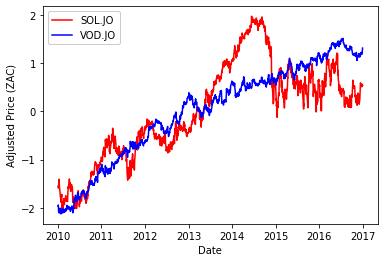

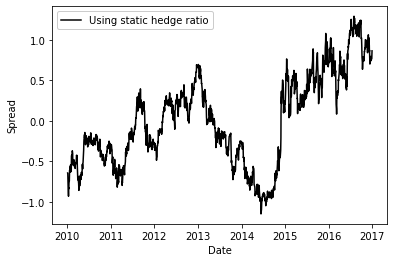

(array([[-1.58999033],
       [-1.56290951],
       [-1.54312849],
       ...,
       [ 0.55126109],
       [ 0.5581571 ],
       [ 0.54070181]]), array([[-1.96447719],
       [-1.94427386],
       [-2.00707562],
       ...,
       [ 1.22682169],
       [ 1.27261432],
       [ 1.31147684]]), Date
2010-01-04   -0.643923
2010-01-05   -0.646211
2010-01-06   -0.725442
2010-01-07   -0.778824
2010-01-08   -0.823398
                ...   
2016-12-23    0.761515
2016-12-27    0.761515
2016-12-28    0.768976
2016-12-29    0.809041
2016-12-30    0.862401
Length: 1752, dtype: float64, Date
2017-01-03    0.275087
2017-01-04    0.402202
2017-01-05    0.407795
2017-01-06    0.333441
2017-01-09    0.469914
                ...   
2019-12-23    0.214431
2019-12-24    0.225420
2019-12-27    0.153253
2019-12-30    0.219724
2019-12-31    0.160056
Length: 752, dtype: float64, 0.8305425687918003, array([-0.64392254, -0.64621098, -0.72544172, ...,  0.15325271,
        0.21972396,  0.16005569]))


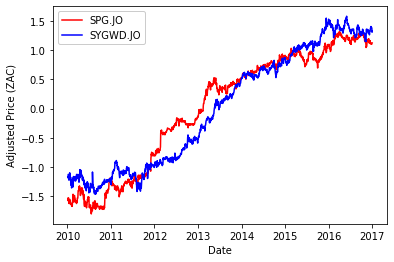

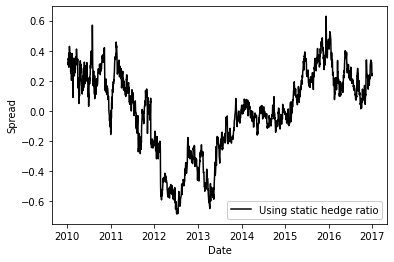

(array([[-1.5537516 ],
       [-1.5537516 ],
       [-1.53110454],
       ...,
       [ 1.11374091],
       [ 1.11759878],
       [ 1.122599  ]]), array([[-1.17329909],
       [-1.18458834],
       [-1.16486547],
       ...,
       [ 1.34806979],
       [ 1.30558972],
       [ 1.32121505]]), Date
2010-01-04    0.319115
2010-01-05    0.307826
2010-01-06    0.305796
2010-01-07    0.346831
2010-01-08    0.344781
                ...   
2016-12-23    0.321118
2016-12-27    0.321118
2016-12-28    0.278296
2016-12-29    0.232110
2016-12-30    0.242933
Length: 1752, dtype: float64, Date
2017-01-03   -2.123474
2017-01-04   -2.163168
2017-01-05   -2.132665
2017-01-06   -2.069174
2017-01-09   -2.026794
                ...   
2019-12-23    3.379157
2019-12-24    3.474996
2019-12-27    3.325570
2019-12-30    3.461651
2019-12-31    3.483955
Length: 752, dtype: float64, 0.9605230310826843, array([0.31911511, 0.30782585, 0.30579571, ..., 3.32557042, 3.46165124,
       3.48395481]))


In [ ]:
# For each asset pair
#pair_1 = pairs_setup('NED.JO','NRP.JO')
#pair_2 = pairs_setup('ANG.JO','GFI.JO')
#pair_3 = pairs_setup('LBH.JO','SNT.JO')
#pair_4 = pairs_setup('ABG.JO','DSY.JO')
#pair_5 = pairs_setup('RDF.JO','SLM.JO')


In [ ]:
# Kalman filter for dynamically tracking the hedge ratio 
# Ive based my matrix maths on the literature of De Moura et al.

import itertools
def Dynamic_Hedge_Ratio(delta,tick_1,tick_2):

  # Get the tickers of the assets in the pair and append a column of 1s
  asset_1 = np.array(data_train[tick_1])
  asset_1 = np.expand_dims(np.vstack([[asset_1],[np.ones(len(asset_1))]]).T,axis=1)
  asset_2 = np.array(data_train[tick_2])

  n = asset_1.shape[0]

  # Now set up the Kalman filter
  # There is a package to do this but better to code it from scratch

  # Covariance matrix
  delta = list(itertools.repeat((delta/(1-delta)),2))
  Vw = np.diag(delta,k=0)
  Ve = 0.001 
  R  = np.array(list(itertools.repeat(0,4))).reshape(2,2)
  P = np.array(list(itertools.repeat(0,4))).reshape(2,2)

  # We call the variable hedge_ratio but it really contains the beta and alpha
  # we are only really interested in the beta, hence the name 
  hedge_ratio = np.array(list(itertools.repeat(0,n*2))).reshape(n,2)

  y_est = np.array(list(itertools.repeat(0,n))).reshape(n,1)
  error = np.array(list(itertools.repeat(0,n))).reshape(n,1)
  Q = np.array(list(itertools.repeat(0,n))).reshape(n,1)

  for i in range(n):
    if i>0: 
      hedge_ratio[i,] = hedge_ratio[i-1,]
      # Covariance prediciton
      R = P + Vw
    
    # Prediciton
    y_est[i] = np.matmul(asset_1[i,],hedge_ratio[i,])
    # Variance prediciton for price
    Q_new = (np.matmul(asset_1[i,],np.matmul(R,asset_1[i,].transpose()))+Ve).reshape(1,1)
    # Error between observation and predicition
    error[i] = asset_2[i]-y_est[i]
    # Kalman gain
    K = np.divide((np.matmul(R,asset_1[i,].transpose())),Q_new[0]).reshape(1,2)
    
    # Update 
    hedge_ratio[i,] = np.add(hedge_ratio[i,],K*error[i])
    P = R - np.matmul(K,np.matmul(asset_1[i,],R).transpose())
  
  return hedge_ratio, error, 

results2 = Dynamic_Hedge_Ratio(0.0001,'ABG.JO','DSY.JO')
print(results2)


In [ ]:
# Spread forecasting using the LSTM
# Done using Keras
# Set up a function so that it is easy to replicate for assets in the portfolio


def spread_forecast(data):

  # Normalize the data 
  normalize = MinMaxScaler(feature_range=(0,1))
  df = normalize.fit_transform(np.array(data).reshape(-1,1))

  # Shape the data correctly, LSTM needs it in [[]], [] form 
  def shape_data(df,look_back):
    xs, ys = [],[]

    for i in range (len(df)-look_back-1):
      xs.append(df[i:i+look_back])
      ys.append(df[i+look_back])

    return np.array(xs), np.array(ys)

  X, y = shape_data(df,look_back=30)
  # Check we have the correct shape arrays
  #X.shape, y.shape

  # Training, validation and testing split
  split = int(0.70*len(X))
  split_2 =int(0.60*len(X))
  X_train, y_train = X[:split_2], y[:split_2]
  X_val, y_val = X[split_2+1:split], y[split_2+1:split]
  X_test, y_test = X[split+1:], y[split+1:]

  return X_train, y_train, X_val, y_val, X_test, y_test


  #row = [[a] for a in df[i:i+look_back]]

In [ ]:
# Shape the spreads ready for LSTM
pair1_spread = spread_forecast(pairs_setup('NED.JO','NRP.JO')[5])
pair2_spread = spread_forecast(pairs_setup('ANG.JO','GFI.JO')[5])
pair3_spread = spread_forecast(pairs_setup('LBH.JO','SNT.JO')[5])
pair4_spread = spread_forecast(pairs_setup('RDF.JO','SLM.JO')[5])
pair5_spread = spread_forecast(pairs_setup('PIK.JO','SPP.JO')[5])


In [ ]:
# Building and training the LSTMs
model1 = Sequential()
model1.add(InputLayer((30,1)))
model1.add(LSTM(45))
model1.add(Dense(5,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 45)                8460      
                                                                 
 dense_6 (Dense)             (None, 5)                 230       
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 8,696
Trainable params: 8,696
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Set model checkpoints to save the best models
cp = ModelCheckpoint('model1', save_best_only = True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
# Fit the models and train
# We find that when we are training 8 epochs is sufficient for this model
# We started running it at 30 epochs 
model1.fit(pair1_spread[0],pair1_spread[1],validation_data=(pair1_spread[2],pair1_spread[3]),epochs=8,callbacks=[cp])


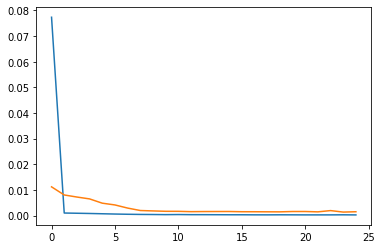

In [ ]:
# Plot the training loss 
loss = model1.history.history['loss']
plt.plot(loss)

# Plot the validation loss
val_loss = model1.history.history['val_loss']
plt.plot(val_loss)

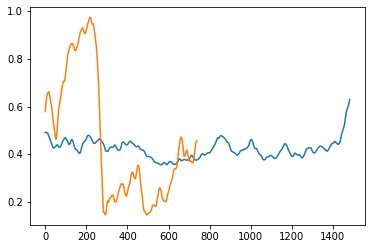

In [ ]:
# Predictions compared to actuals 
train_predictions = model1.predict(pair1_spread[0]).flatten()
train_actual = pair1_spread[1]
plt.plot(train_predictions)

# Obtain test predictions
test_predictions_1 = model1.predict(pair1_spread[4]).flatten()
testPredictions_1('/content/gdrive/MyDrive/Statistics Honours Research Project/pair_1_predictions.csv')

In [ ]:
# Multistep ahead forecast, for 5 days
# Since we do not want a naive lag forecast

len(pair1_spread[4])
# 741
# Remeber our look back period is 30 days

x_input = pair1_spread[5][711:].reshape(1,-1)

# Create a temporary holder that will be replaced by predcictions
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=30
i=0

# Now we iterate through and replace the input with our predictions if days<30
while(i<5):
    
    if(len(temp_input)>30):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
      
        yhat = model1.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model1.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.45653483]
31
1 day input [0.3557253  0.37410514 0.34686383 0.33371365 0.35308189 0.35394346
 0.40047618 0.42363024 0.42422112 0.42680928 0.4225805  0.44799203
 0.44988877 0.4537195  0.45693653 0.46186921 0.46140078 0.48300502
 0.46969458 0.46779178 0.44669723 0.43875841 0.42940496 0.42920413
 0.43856304 0.44671654 0.44653469 0.45609942 0.44478199 0.45653483]
1 day output [[0.4567238]]
2 day input [0.37410514 0.34686383 0.33371365 0.35308189 0.35394346 0.40047618
 0.42363024 0.42422112 0.42680928 0.4225805  0.44799203 0.44988877
 0.4537195  0.45693653 0.46186921 0.46140078 0.48300502 0.46969458
 0.46779178 0.44669723 0.43875841 0.42940496 0.42920413 0.43856304
 0.44671654 0.44653469 0.45609942 0.44478199 0.45653483 0.45672381]
2 day output [[0.45682225]]
3 day input [0.34686383 0.33371365 0.35308189 0.35394346 0.40047618 0.42363024
 0.42422112 0.42680928 0.4225805  0.44799203 0.44988877 0.4537195
 0.45693653 0.46186921 0.46140078 0.48300502 0.46969458 0.46779178
 0.44669723 0.4387584

In [ ]:
day_new=np.arange(1,31)
day_pred=np.arange(31,36)

plt.plot(lst_output)
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
##########################################
######## LSTM for spread Forecast #########
# Author: Matthew Benning
############################################

d = pd.read_excel('/content/gdrive/MyDrive/Statistics Honours Research Project/jse_data_ready.xlsx',index_col=0)
# Converting the date column to datetime object 
data = data.dropna()


# Spread calculation 

def spread (tick1,tick2,data_train,data_test):

  asset_1= np.array(data[tick_1]).reshape(-1,1)
  asset_2= np.array(data[tick_2]).reshape(-1,1)

  # Obtain the static hedge ratio, using OLS
  reg = LinearRegression().fit(asset_1 ,asset_2)
  static_hedge_ratio = reg.coef_[0][0]

  # Spread
  spread_train = data_train[tick_2] -static_hedge_ratio*data_train[tick_1]
  spread_test = data_test[tick_2] -static_hedge_ratio*data_test[tick_1]
  spread = np.hstack([spread_train,spread_test])

  return spread_train, spread_test,spread

portfolio np.array(















